# <center>**APRENDIZAJE AUTOMÁTICO**</center>
# <center>**Predicción de precios de vivienda**</center>
## <center>**Grupo: lacasademickeymouse**</center>

# Integrantes

- Iñigo González-Varas Vallejo
- Eduardo De La Vega Fernández
- Juan Misas Higuera 
- Fernando Martín San Bruno

# Introducción

Se realizará un estudio de un problema de regresión para la estimacion de precios de viviendas. En primer lugar, haremos un procesamiento y análisis de los datos basado  en el estudio, tranformación, eliminación y agregación en los datos proporcionados para el entrenamiento del modelo. Posteriormente, se probarán diferentes modelos de regresión, incluyendo LinearRegresion, RandomForestRegressor, ElasticNet, Lasso, Ridge, DecisionTreeRegressor, KNeighborsRegressor, GradientBoostRegressor, AdaBoostRegressor y CatBoostRegressor. Como último paso se hará la busqueda de los hiperparámetros óptimos, entrenando modelos que obtengan el mejor resultado en la métrica de evaluación del problema.

# Imports

In [1]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import pprint as pp
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import scipy.stats as stats
from catboost import CatBoostRegressor
import warnings
import datetime

warnings.filterwarnings('ignore')

# Funciones

En esta sección se definen las funciones que se utilizarán en el resto del cuaderno. Fundamentalmente, estas funciones se pueden dividir en las siguientes categorías:  
- Funciones de visualización (distribuciones, gráficos de dispersión, matriz de correlación, desempeño en el set de test)
- Funciones de preprocesamiento de datos (codificación, normalización, división de datos) 

**FUNCIONES DE VISUALIZACIÓN**

- **visualize_dataframe_distributions(df):** visualiza la distribución de todas las columnas de un DataFrame. Muestra gráficos para las columnas numéricas, categóricas y de fecha/hora en una cuadrícula.
- **plot_correlation_matrix(df):** muestra una visualización colorida de la matriz de correlación del DataFrame, lo que facilita la identificación de relaciones entre variables.

**FUNCIONES DE PROCESAMIENTO DE DATOS**

- **inmax_norm(df, variables_reales):** toma columnas numéricas especificadas y las normaliza entre 0 y 1 utilizan- do la normalización Min-Max.

- **zscore_norm(df, variables_reales):** aplica la normalización Z-Score a columnas numéricas especificadas, centra- ndo y escalando los datos según s:u media y desviación estándar.

- **colone_hot_encoding(df, variables_categoricas):** puedes convertir columnas categóricas en un conjunto de colu-  binarias, una técnica útil para modelos qu:e no manejan variables categóricas directamente.

- **extract_postal_hierarchy(df):** extrae jerarquías de una columna de códigos postales, creando nuevas columnas q- ue representan grupos postales y regiones basadas en los códigos.

- **zscore_norm_price(df):** se centra en la columna 'Precio', normalizándola usando el Z-Score, mientras que zscor- e_norm_price_inverse(np_array) realiza la operación inversa, des-normalizando un arreglo de precios.


l_y_split(df, target)idivide un DataFrame en un conjunto de variables independientes y una variable objetivo- , preparándolo para el modelado.DataFrame en un conjunto de variables independientes y una variable objetivo, preparándolo para el modelado.nto- train_model y test_model sirven para entrenar modelos con datos y luego probar su rendimiento, respectivamente.
n - modelo y los valores reales, destacando el err presenta un gráfico comparativo entre las predicciones de un modelo y los valores reales, destacando el error de predicción.de - umnas del DataFrame con la columna 'Precio'.

In [2]:
price_mean = 0
price_std = 0

def visualize_dataframe_distributions(df):
    # Filtrar columnas por tipo de datos
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    n = len(df.columns)  # Numero total de columnas
    side_length = int(np.ceil(np.sqrt(n)))  # Calcula la longitud del lado de la cuadrícula
    
    # 
    fig, axes = plt.subplots(nrows=side_length, ncols=side_length, figsize=(50, 50))
    fig.tight_layout(pad=4.0)
    
    for ax in axes.ravel():
        ax.axis('off')  # Hide all axes initially

    # Plotting numeric columns
    for i, col in enumerate(numeric_cols):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        ax.hist(df[col], bins=30, edgecolor='k')
        ax.set_title(col)
    
    # Plotting categorical columns
    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    
    # Plotting datetime columns
    for i, col in enumerate(datetime_cols, start=len(numeric_cols) + len(categorical_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().sort_index().plot(ax=ax)
        ax.set_title(col)
        
    plt.show()

def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[0:2]
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

def plot_correlation_matrix(df):
    corr = df.corr()
    corr = abs(corr)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred


def visualize_test(y_test, y_pred, ax, model_name):
    perc_diff = abs((y_pred - y_test) / y_test) * 100
    sorted_indexes = np.argsort(perc_diff)[::-1] 
    
    y_test_sorted = y_test.iloc[sorted_indexes]
    y_pred_sorted = y_pred[sorted_indexes]
    
    # paired = sorted(list(zip(y_test, y_pred)))
    # y_test_sorted, y_pred_sorted = zip(*paired)

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)

    print('MAE: {:}'.format(mae/1000))
    print('MAPE: {:.4}'.format(mape*100))

    num_range = np.arange(0, len(y_test))
    ax.plot(num_range, y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(num_range, y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()
    
    return sorted_indexes


def plot_against_precio(df):
    """
    Plot all columns in dataframe df against 'Precio'.
    Assumes that 'Precio' is one of the columns in df.
    """
    # Ensure that Seaborn's aesthetics are being used
    sns.set(style="whitegrid")
    
    # Number of columns to be plotted against 'Precio'
    n = df.shape[1] - 1  # subtract 1 because we won't plot 'Precio' against itself
    
    # Create subplots; You can adjust the size (e.g., figsize) as per your requirements
    fig, axes = plt.subplots(n, 1, figsize=(8, 5*n))
    
    # For every column other than 'Precio', plot it against 'Precio'
    for i, column in enumerate([col for col in df.columns if col != 'Precio']):
        sns.scatterplot(data=df, x='Precio', y=column, ax=axes[i])
        axes[i].set_title(f'{column} vs. Precio')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


def visualize_price_distribution(df, column_name="Precio", title="Price Distribution", color="skyblue", kde=True):
    
    # Check if the column exists in the dataframe
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the dataframe!")
        return
    
    # Set the style for a fancier look
    sns.set(style="whitegrid")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=kde, color=color, bins=30, edgecolor="black", linewidth=0.5)
    
    # Decorate the plot
    plt.title(title, fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y")
    
    # Display the plot
    plt.tight_layout()
    plt.show()



# Procesamiento de datos

En esta parte del cuaderno definimos la pipeline de procesamiento de datos quehemos encontrado más efectiva para este problema y para el entrenamiento de nuestros modelos. En esta pipeline se definen las transformaciones que se aplicarán a los datos antes de ser utilizados para entrenar los modelos, como normalización, eliminación de columnas poco relevantes para nuestros modelos, creación de nuevas columnas a partir de otras, etc.  
Realmente en este cuaderno se encuentra la solución final que hemos utilizado para entrenar nuestros modelos finales, así como algunas transformaciones que probamos y decidimos no utilizar. Ha sido un proceso iterativo de análisis de los datos y prueba de modelos, en el que hemos ido probando diferentes transformaciones y modelos, y hemos ido descartando los que no nos han dado buenos resultados.

Comenzamos cargando el dataset y haciendo una primera exploración de los datos.

In [3]:
df = pd.read_csv('train.csv')
df.head()

Id               Tipo  FechaConstruccion  FechaReforma  Plantas     Plan   
0   1  Chalet individual               2003          2003        2  Antiguo  \
1   2  Chalet individual               1976          1976        1  Antiguo   
2   3  Chalet individual               2001          2002        2  Antiguo   
3   4  Chalet individual               1915          1970        2    Nuevo   
4   5  Chalet individual               2000          2000        2  Antiguo   

   PAU               CatParcela  PerimParcela  Superficie  ...  AguaCorriente   
0    0  Residencial unifamiliar         79.25      785.03  ...              1  \
1    0  Residencial unifamiliar         97.54      891.87  ...              1   
2    0  Residencial unifamiliar         82.91     1045.16  ...              1   
3    0  Residencial unifamiliar         73.15      887.22  ...              1   
4    0  Residencial unifamiliar        102.41     1324.80  ...              1   

   FosaSeptica        Situacion     CP  ProxCarretera  ProxCallePrincipal   
0            0         Interior  60061              0                   0  \
1            0  Frontal 2 lados  50018              0                   1   
2            0         Interior  60061              0                   0   
3            0          Esquina  62451              0                   0   
4            0  Frontal 2 lados  60706              0                   0   

   ProxViasTren Estado RatingEstrellas  Precio  
0             0      5             3.5  375497  
1             0      8             3.0  339946  
2             0      5             3.5  402511  
3             0      5             3.5  272706  
4             0      5             4.0  450236  

[5 rows x 31 columns]

Podemos observar que el dataset contiene 31 columnas y 1000 filas. La columna 'Precio' es la variable objetivo, mientras que las demás columnas son variables independientes que pueden ser utilizadas para predecir el precio de una propiedad (a excepción de Id, que es la identificación de la propiedad).

In [4]:
columns = df.columns
rows = len(df)
print('Número de filas:', rows)
print('Número de columnas:', len(columns))
print(columns)


Número de filas: 1000
Número de columnas: 31
Index(['Id', 'Tipo', 'FechaConstruccion', 'FechaReforma', 'Plantas', 'Plan',
       'PAU', 'CatParcela', 'PerimParcela', 'Superficie', 'Aseos',
       'Habitaciones', 'Garaje', 'Piscina', 'Vallada', 'CallePavimentada',
       'Callejon', 'Formato', 'TipoDesnivel', 'Desnivel', 'GasNatural',
       'AguaCorriente', 'FosaSeptica', 'Situacion', 'CP', 'ProxCarretera',
       'ProxCallePrincipal', 'ProxViasTren', 'Estado', 'RatingEstrellas',
       'Precio'],
      dtype='object')


Hacemos un análisis de valores nulos, vemos que las columnas Plan y Parcela son las que los contienen. Como son columnas categóricas, podemos reemplazar los valores nulos por 'Sin Información'. Sin embargo, decidimos eliminar estas columnas ya que no aportan información relevante para el análisis. 

In [5]:
#look for nan value
nans = df.isna().sum()
nans = nans[nans > 0]
print(nans)

Plan            233
PerimParcela    173
dtype: int64


A continuación, establecemos la columnas Id como índice del dataframe comenzamos a eliminar columnas que no aportan información relevante para el análisis:
- **AguaCorriente, FosaSeptica y GasNatural**: todas las propiedades tienen estos servicios a excepción de una, por lo que no aportan información relevante.
- **Piscina**: tras hacer un análisis de correlación con el precio, vemos que no existe una relación significativa entre ambas variables, y que pocas muestras tienen piscina.
- **Plan y Parcela**: como se mencionó anteriormente, estas columnas contienen valores nulos y no aportan información relevante.

In [6]:
df.set_index('Id', inplace=True)
df.drop(['AguaCorriente', 'GasNatural', 'FosaSeptica', 'Piscina', 'Plan', 'PerimParcela'], axis=1, inplace=True)

Una vez eliminadas esas columnas, vamos a tratar en primer lugar las columnas con valores numéricos (enteros y decimales). 

**Código Postal**  
El código postal es una variable que puede contener mucha información sobre la propiedad, ya que nos permite identificar la zona en la que se encuentra. Sin embargo, el código postal es una variable categórica, por lo que no podemos utilizarla directamente en un modelo de regresión. Para poder utilizarla, la dividimos en dos columnas: **GrupoPostal** y **RegionPostal**. La primera contiene el primer dígito del código postal, mientras que la segunda contiene los dos primero. De esta forma, podemos utilizar estas columnas como variables categóricas en el modelo y ver si existe correlación entre la zona donde se ubica la propiedad y el precio.

In [7]:
df = extract_postal_hierarchy(df)

**Variables sintéticas**  
A partir de las columnas existentes, queremos crear columnas nuevas que plasmen información relevante para el análisis e interacciones entre variables de entrada. Durante el desarrollo del proyecto creamos varias columnas que posteriormente no utilizamos dado que o bien introducían ruido o no eran relevantes para nuestros modelos. Estas variables se encuentran comentadas en la parte inferior de la celda. Las columnas que creamos incluyen:   

- **Utilizadas en el modelo final**
    - SinGaraje: realiza la inversa de la columna Garaje, es decir, si la propiedad no tiene garaje, toma el valor 1, y si tiene garaje, toma el valor 0.
    - 3plantas: indica si la casa tiene 3 plantas, ya que se relaciona con un precio más bajo.
    - AgeOfHouse y YearsSinceReform: indican la antigüedad de la casa y el tiempo transcurrido desde la última reforma, respectivamente.   


- **Relaciones entre variables utilizadas en el modelo final**: creamos columnas que representan la interacción entre variables de entrada que tienen una correlación significativa con el precio. 
    - aseos+hab*rating: columna creada a partir de las variables que más correlación tienen con el precio. 
    - synth4-7: variables sintéticas obtenidas de la combinación de las columnas de entrada. Resultan en distribuciones con una alta correlación con el precio, con forma lineal y de "plátano" (curva exponencial)
  
- **No utilizadas en el modelo final**  
    - Reformada: si la vivienda está reformada o no
    - TotalRooms: número total de habitaciones
    - AvgProximity: media entre las variables relacionadas con la distancia a carretera, calle principal y vias de tren. 

In [8]:
current_year = datetime.datetime.now().year

df['SinGaraje'] = df['Garaje'].apply(lambda x: 1 if x == 0 else 0)
df['3plantas'] = df['Plantas'].apply(lambda x: 1 if x == 3 else 0)
df['AgeOfHouse'] = current_year - df['FechaConstruccion']
df['YearsSinceReform'] = current_year - df['FechaReforma']
df['aseos+hab*rating'] = (0.7*df['Aseos'] + 0.3*df['Habitaciones']) * df['RatingEstrellas']
df['synth4'] = np.log1p(df['aseos+hab*rating'] * df['Superficie'])
df['synth5'] = np.log1p(df['aseos+hab*rating'] * df['Estado'])
df['synth6'] = np.log1p(df['Estado'] * df['Superficie'])
df['synth7'] = np.log1p(df['aseos+hab*rating'] * df['Superficie'] * df['Estado'])

# df['Reformada'] = df['FechaConstruccion'] != df['FechaReforma']
# df['Reformada'] = df['Reformada'].astype(int)
#df['TotalRooms'] = df['Aseos'] + df['Habitaciones']
#df['AvgProximity'] = (df['ProxCarretera'] + df['ProxCallePrincipal'] + df['ProxViasTren']) / 3
#df['rooms/rating'] = df['Habitaciones'] / df['RatingEstrellas']

Tras hacer análisis de correlación y haber entrenado algunos modelos como regresión lineal (realmente esto es un proceso iterativo en el que íbamos de las celdas posteriores a las anteriores)  decidimos eliminar las columnas que no aportaban información relevante para el análisis (por ejemplo las que en regresión lineal tienen menos importancia), o cuya información ya estaba contenida en alguna de las variables creadas anteriormente (alta correlación con otras variables).

In [9]:
df.drop(['FechaConstruccion', 'FechaReforma', 'Garaje', 'Formato', 'TipoDesnivel', 'Desnivel', 'Situacion', 'Plantas', 'PAU', 'Vallada', 'Callejon', 'CallePavimentada', 'Aseos', 'Habitaciones'], axis=1, inplace=True)

Hacemos one-hot encoding de todas las variables categóricas, e igual que hicimos en el paso anterior, eliminamos aquellas que no son relevantes para nuestros modelos y mantenemos el resto. 

In [10]:
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
df = one_hot_encoding(df, variables_categoricas)
df.drop(['Tipo_Chalet individual', 'CatParcela_Residencial tipo 2', 'CatParcela_Residencial unifamiliar', 'CP_50012', 'CP_50018', 'CP_60645', 'CP_61704', 'CP_62451'], axis=1, inplace=True)

Obtenemos las variables reales y enteras (float e int) y las normalizamos utilizando la normalización Z-Score (centrando y escalando los datos según su media y desviación estándar). No lo hacemos con el precio ya que hay más problemática relacionada con él (outliers, distribución no normal, etc) y la trataremos más adelante. 

In [11]:
variables_reales = df.columns[df.dtypes == 'float64']
variables_enteras = df.columns[df.dtypes == 'int64']
variables_enteras = variables_enteras.drop('Precio')
df = zscore_norm(df, variables_reales)
df = zscore_norm(df, variables_enteras)

En esta celda podemos ver las funciones que hemos utilizado para visualizar distribuciones o relaciones entre variables. Incluyen una función que muestra todas las distribuciones de las variables (visualize_dataframe_distributions), gráficas que muestran relación entre columnas y el precio (plot_against_precio), gráficas que muestran la relación entre columnas dos a dos (sns.pairplot)

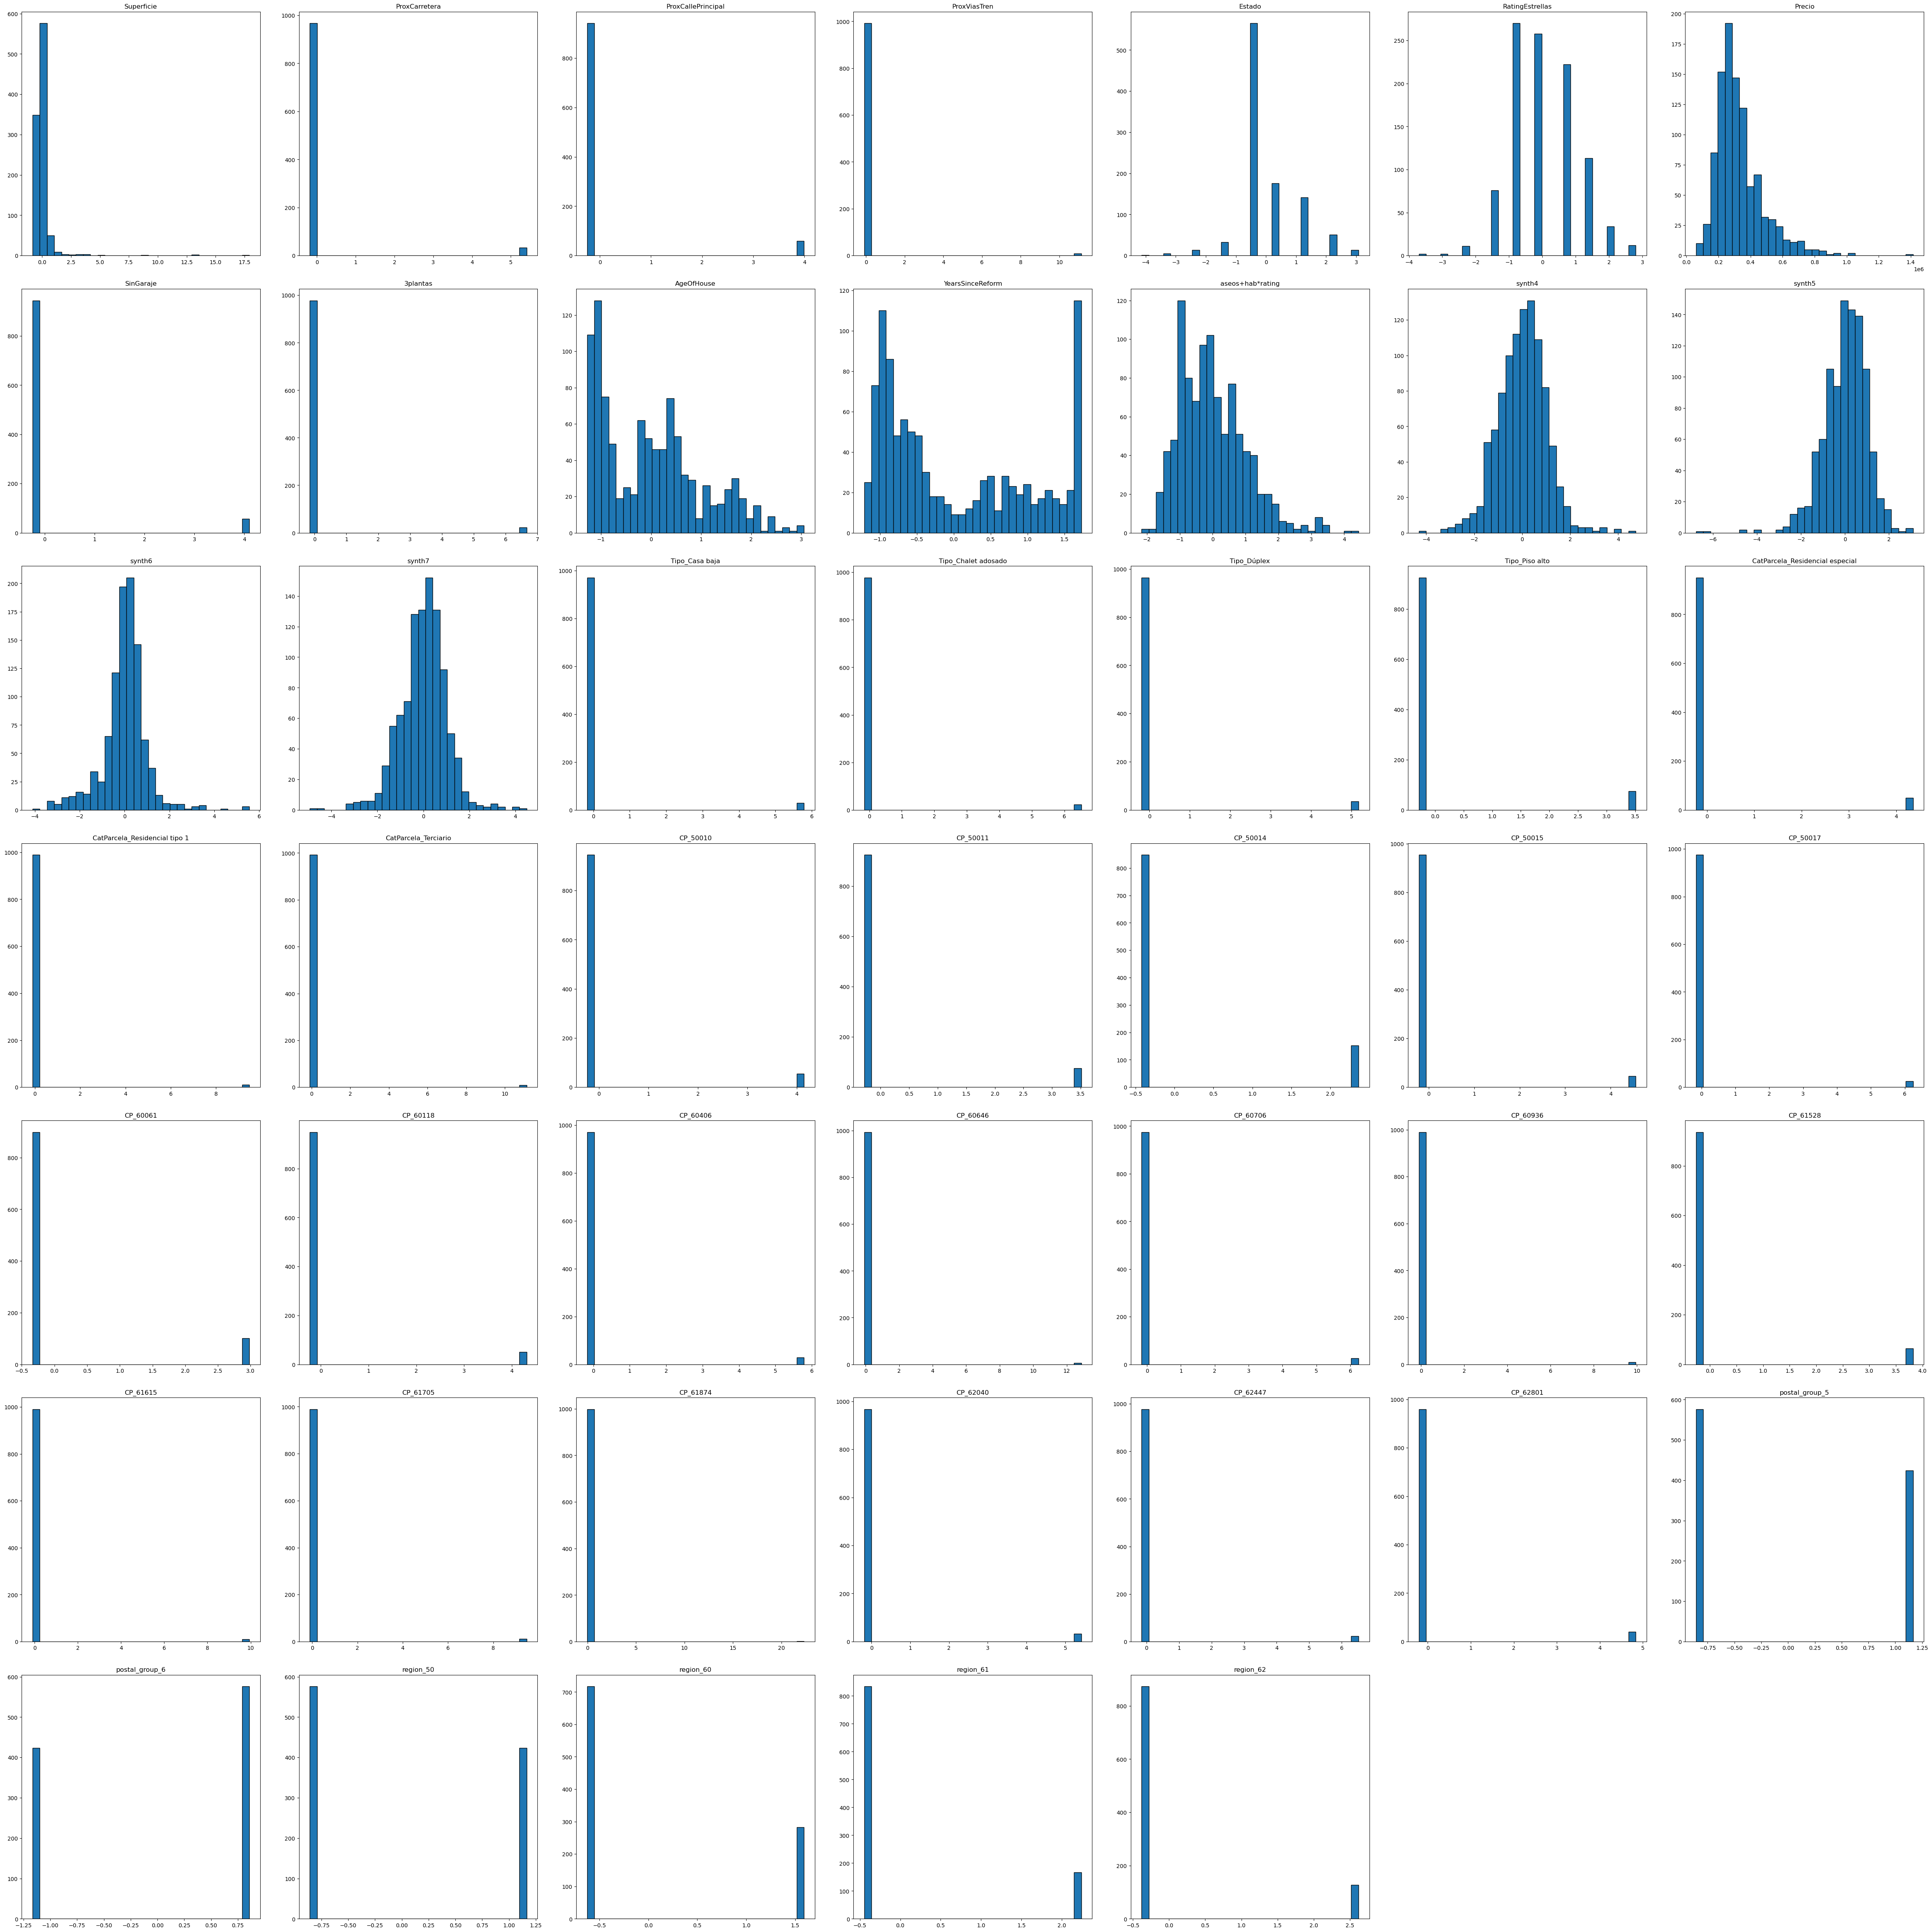

In [12]:
visualize_dataframe_distributions(df)
#sns.pairplot(df)
#plot_against_precio(df)

# Display the plots
plt.show()

En un momento dado, pensamos que era buena idea calcular si alguna de las columnas tenía mucho skew (asimetría) y aplicarle una transformación logarítmica para reducirlo. Sin embargo, tras hacer pruebas con modelos, vimos que no mejoraba el rendimiento, por lo que decidimos no utilizarlo. De todos modos, dejamos el código en la celda siguiente por si en algún momento queremos volver a utilizarlo. Se utiliza una función de scipy.stats para determinar si existe asimetría en la distribución, y para aquellas columnas que tienen asimetría se aplica el logaritmo. Se eliminan valores problemáticos (infinitos) y se normalizan los datos.

In [13]:
# from scipy.stats import skew
# numeric_features = df.dtypes[df.dtypes != object].index
# numeric_features = numeric_features.drop('Precio')
# skewed_features = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
# high_skew = skewed_features[skewed_features > 0.5]
# skew_index = high_skew.index

# # Normalize skewed features using log_transformation
    
# for i in skew_index:
#     df[i] = np.log1p(df[i])

# inf=pd.DataFrame(np.isinf(df).sum() ,columns=['Inf_sum'])
# inf['feat']=inf.index
# inf=inf[inf['Inf_sum']>0]
# inf=inf.sort_values(by=['Inf_sum'])
# inf.insert(0,'Serial No.',range(1,len(inf)+1))
# print(inf)

Con la siguiente función podemos ver la matriz de correlación de las variables. Esta matriz nos permite ver la relación entre las variables de entrada y el precio, y entre las variables de entrada entre sí. Los valores están en el rango de 0 a 1, ya que vemos la correlación entre variables. Una correlación de 0 indica que no existe relación entre las variables (denotada en azul oscuro), mientras que una correlación de 1 indica que existe una relación lineal perfecta entre las variables (denotada en rojo oscuro).

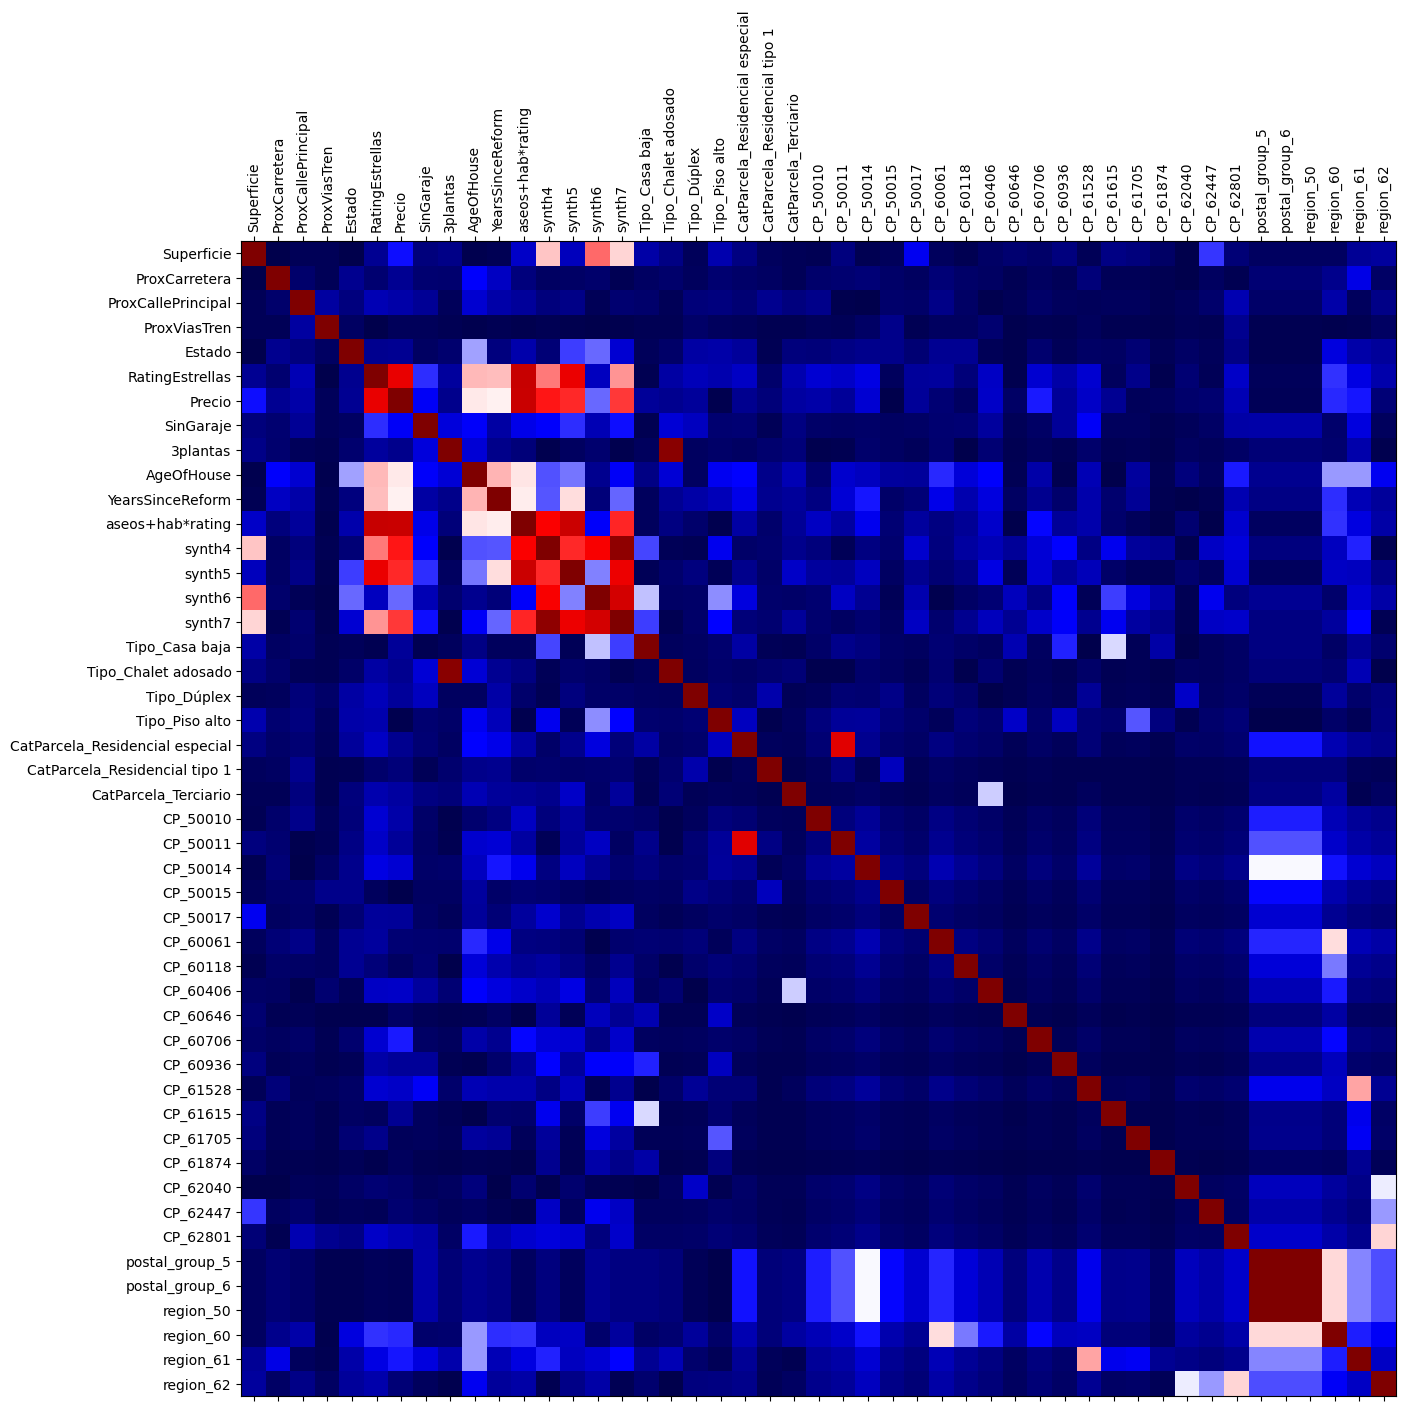

In [14]:
plot_correlation_matrix(df)

A continuación, utilizando los valores de la matriz de correlación obtenidos, se han ido realizando pruebas deescartando las variables predictoras que poseían una alta correlación(mayor a un umbral preestablecido de 0.5) y por lo tanto podían dificultar el entrenamiento introduciendo ruido al modelo. 

In [15]:
# corr = df.corr()
# umbral = 0.5
# # Encontrar características altamente correlacionadas
# caract_alta_correlacion = set()
# for i in range(len(corr.columns)):
#     for j in range(i):
#         if abs(corr.iloc[i, j]) < umbral:
#             colname = corr.columns[i]
#             caract_alta_correlacion.add(colname)
# caract_alta_correlacion.remove('Precio')
# print(caract_alta_correlacion)

# Precio: distribución y problemática

Es importante conocer cuál es la distribución de la variable objetivo, ya que esto nos permite saber si es necesario aplicar alguna transformación a los datos. En este caso, podemos ver que la distribución del precio no es normal, sino que tiene una cola larga hacia la derecha. Esto puede ser un problema para los modelos, ya que puede dificultar la regresión en muchos casos.

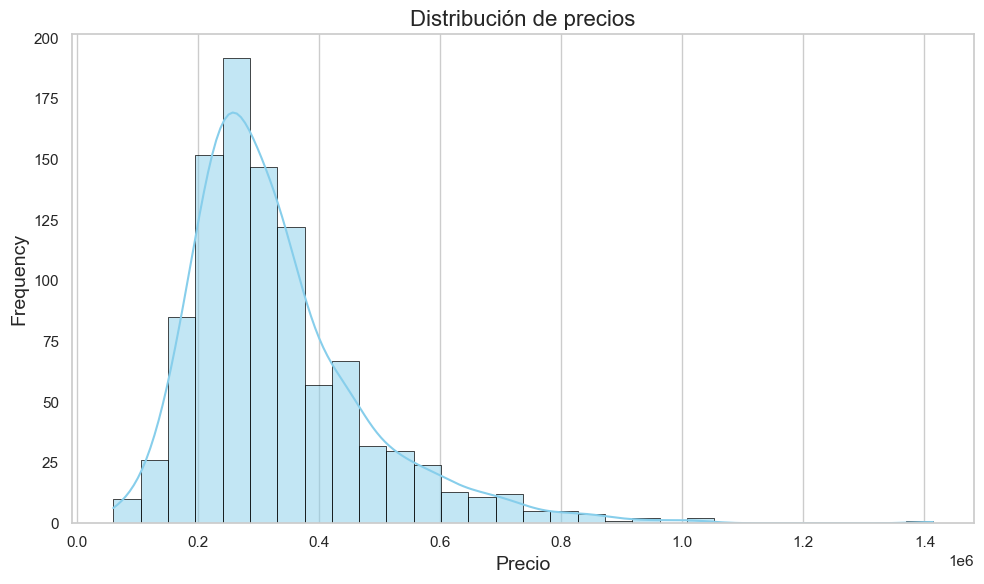

In [16]:
visualize_price_distribution(df, title="Distribución de precios")

Para lidiar con este problema hemos probado varias soluciones posibles. A continuación, enumeramos las soluciones que hemos probado y no hemos incluido en nuestro modelo final, y las que sí hemos incluido. Estas soluciones están basadas en varios artículos y literatura consultados que hemos incluido en la bibliografía. 

- Smogn (smote): SMOTE Técnica de Sobremuestreo Sintético de Minorías (por sus siglas en inglés). Es un algoritmo utilizado para abordar el problema del desequilibrio de clases en conjuntos de datos de aprendizaje automático. SMOTE solo está disponible actualmente para problemas de clasificación, pero investigadores de la Universidad de Oporto han desarrollado smogn, una variante para regresión. A pesar de ser un state-of-the-art en el tratamiento de desequilibrios en regresión, no hemos obtenido buenos resultados con él.

  
- Modificación de la distribución: hemos probado a aplicar una técnica de muestreo que modifica la distribución de los datos para que se parezca más a una distribución normal. Sin embargo, no hemos obtenido buenos resultados con esta técnica, ya que modifica demasiado la distribución original y hace que el aprendizaje sea complejo.


  
- Eliminación de outliers: dada la distribución de los datos, hemos probado a eliminar los valores del final de la distribución, concretamente los que se encuentran por encima de 1M en precio. Hemos obtenido buenos resultados con esta técnica y la hemos incluido en nuestro modelo final. Asimismo, en un inicio eliminábamos valores de superficie mayores que un umbral, pero vimos que eso empeoraba los resultados.


  
- Transformación logarítmica: la transformación logarítmica de la variable precio y posterior desnormalización ha demostrado buenos resultados en la predicción del precio de las viviendas, dado que la distribución de los datos se asemeja más a una distribución normal. 


  
- Bootstrap:  el bootstrap es menos sensible a las peculiaridades de una distribución específica y puede proporcionar estimaciones más robustas en presencia de asimetrías.

In [17]:
#----------------------------------------
# SMOGN
#----------------------------------------
# from smogn import smoter
# df = smoter(data=df, y='Precio', k = 5, pert = 0.5, samp_method = 'balance')

#----------------------------------------
# Modificación de la distribución de precios
#----------------------------------------

#Calculate the number of bins
# num_bins = 10
# bins = np.linspace(train['Precio'].min(), train['Precio'].max(), num_bins+1)
# mid_points = (bins[:-1] + bins[1:]) / 2

# # Bin the data
# train['binned'] = pd.cut(train['Precio'], bins=bins)
# print(train['binned'].value_counts())
# # Desired normal distribution parameters
# mean = train['Precio'].mean()
# std = train['Precio'].std()

# # Calculate the desired number of samples per bin based on normal distribution
# pdf_values = stats.norm.pdf(mid_points, mean, std)
# desired_samples_per_bin = pdf_values / sum(pdf_values) * len(train)
# print(desired_samples_per_bin)

# # Get unique bin categories
# unique_bins = train['binned'].cat.categories

# # Oversample each bin
# oversampled_dfs = []

# for i, bin_category in enumerate(unique_bins):
#     bin_df = train[train['binned'] == bin_category]
#     num_samples = int(desired_samples_per_bin[i])

#     if not bin_df.empty and num_samples > 0:
#         oversampled_dfs.append(bin_df.sample(num_samples, replace=True))

# if oversampled_dfs:
#     oversampled_train = pd.concat(oversampled_dfs, axis=0).reset_index(drop=True)
#     # Drop the 'binned' column
#     oversampled_train = oversampled_train.drop(columns=['binned'])
# else:
#     print("No bins met the criteria for oversampling.")

# Entrenamiento

Se dividen a continuación los datos del dataset en la muestra de entrenamiento y la de test, con proporciones de 80% y 20%, respectivamente.

In [18]:
train_size = 0.8
train = df.sample(frac=train_size, random_state=1)
test = df.drop(train.index)

Finalmente, en nuestro test de entrenamiento, la combinación de soluciones que hemos aplicado para mejorar la predicción se basa en eliminar colas de la distribución de precios, hacer bootstrap con las muestras de entrenamiento y aplicar una transformación logarítmica para normalizar los datos y cambiar la forma de su distribución ligeramente. 

In [19]:
#----------------------------------------
# Eliminación de outliers
#----------------------------------------

train = train[train['Precio'] < 10**6]
#train = train[train['Superficie'] < 3]
#train['Superficie'] = np.log1p(train['Superficie'])

#----------------------------------------
# Bootstrap
#----------------------------------------

n_iterations = 100  # number of bootstrap samples you want to create
bootstrap_samples = []

for i in range(n_iterations):
    bootstrap_sample = train.sample(n=len(train), replace=True)
    bootstrap_samples.append(bootstrap_sample)

train = pd.concat(bootstrap_samples, axis=0).reset_index(drop=True)

#----------------------------------------
# Normalización
#----------------------------------------

train['Precio'] = np.log1p(train['Precio'])

#----------------------------------------
# Separación de variables
#----------------------------------------

X_train, y_train = x_y_split(train, 'Precio')
X_test, y_test = x_y_split(test, 'Precio')

## Regresión lineal: baseline

Utilizaremos la regresión lineal como baseline para comparar el rendimiento de los demás modelos. En este caso, utilizamos la regresión lineal de scikit-learn, que es una implementación de la regresión lineal con regularización L2. Realmente, veremos que dadas estas condiciones la regresión lineal es uno de los modelos que mejor rendimiento tiene en este problema.

**Métricas**:  
Las métricas utilizadas para comprobar el rendimiento de nuestros modelos van a ser dos, MAE y MAPE, ya que permiten comparar el rendimiento de los modelos independientemente de la escala de los datos, además de ser fácilmente interpretables.
- MAE: Mean Absolute Error. Es el error absoluto medio, es decir, la media de la diferencia entre el valor real y el valor predicho.
- MAPE: Mean Absolute Percentage Error. Es el error porcentual absoluto medio, es decir, la media de la diferencia porcentual entre el valor real y el valor predicho.

MAE: 40.42661997227262
MAPE: 12.01


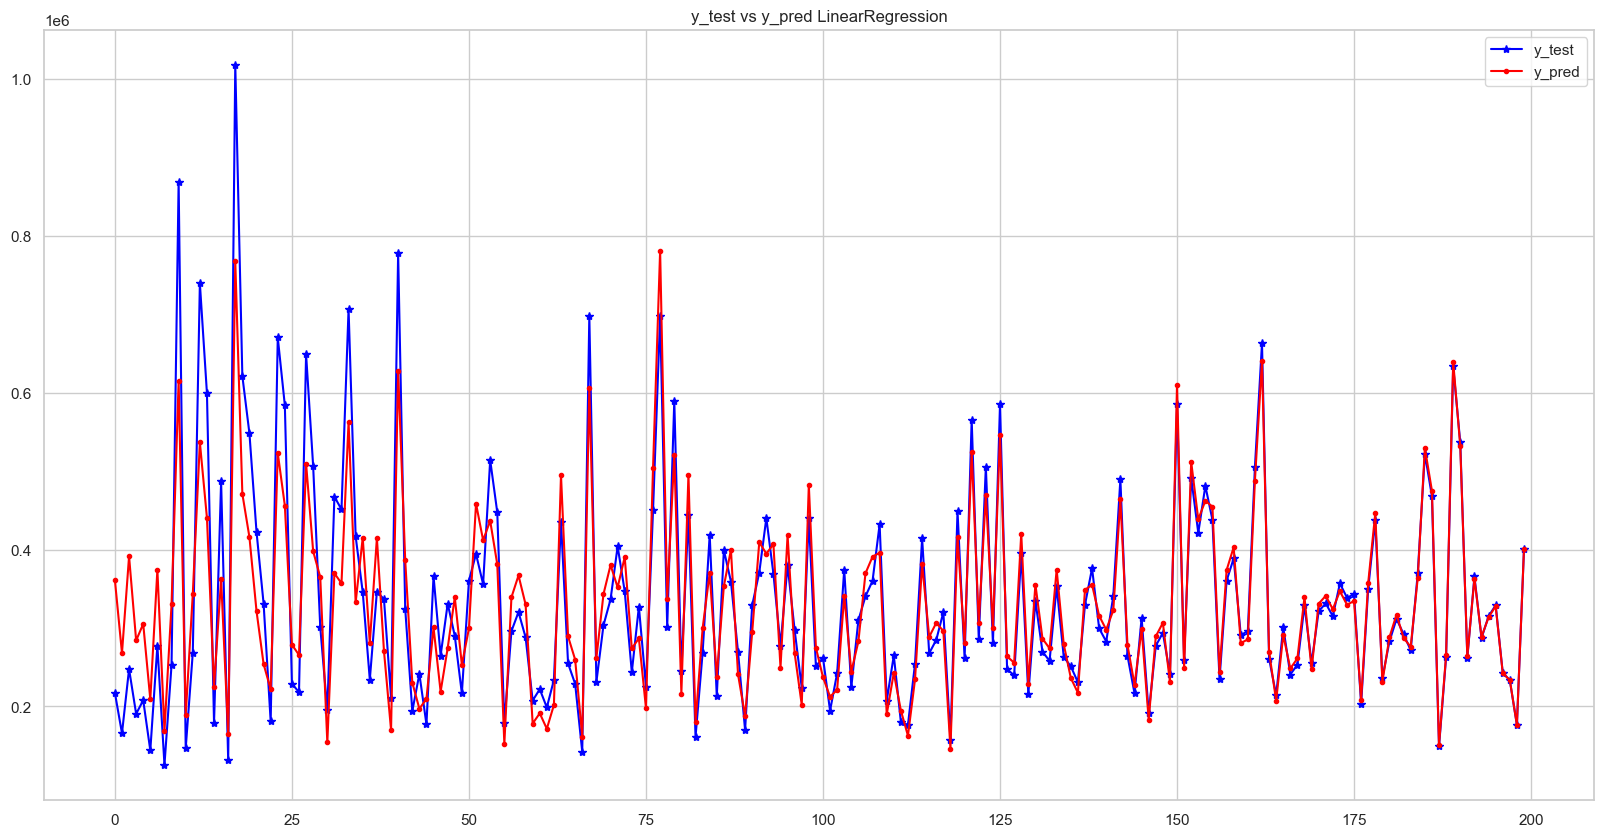

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

model = LinearRegression()
model_name = model.__class__.__name__
trained_model = train_model(model, X_train, y_train)
y_pred = test_model(trained_model, X_test, y_test)

y_pred = np.expm1(y_pred)

indexes = visualize_test(y_test, y_pred, ax=axes, model_name='LinearRegression')

Es importante analizar en qué muestras se cometen los errores más grandes, ya que esto nos permite saber en qué casos el modelo no funciona bien. Para ello, obtenemos las muestras ordenadas por error absoluto y las guardamos en un dataframe, para su posterior análisis. Este ha sido un paso clave en nuestro proceso de entrenamiento de modelos y análisis de resultados, ya que nos ha permitido identificar los casos en los que los modelos fallan y tomar medidas para solucionarlo.

MAE: 39.59228367257448
MAPE: 11.48


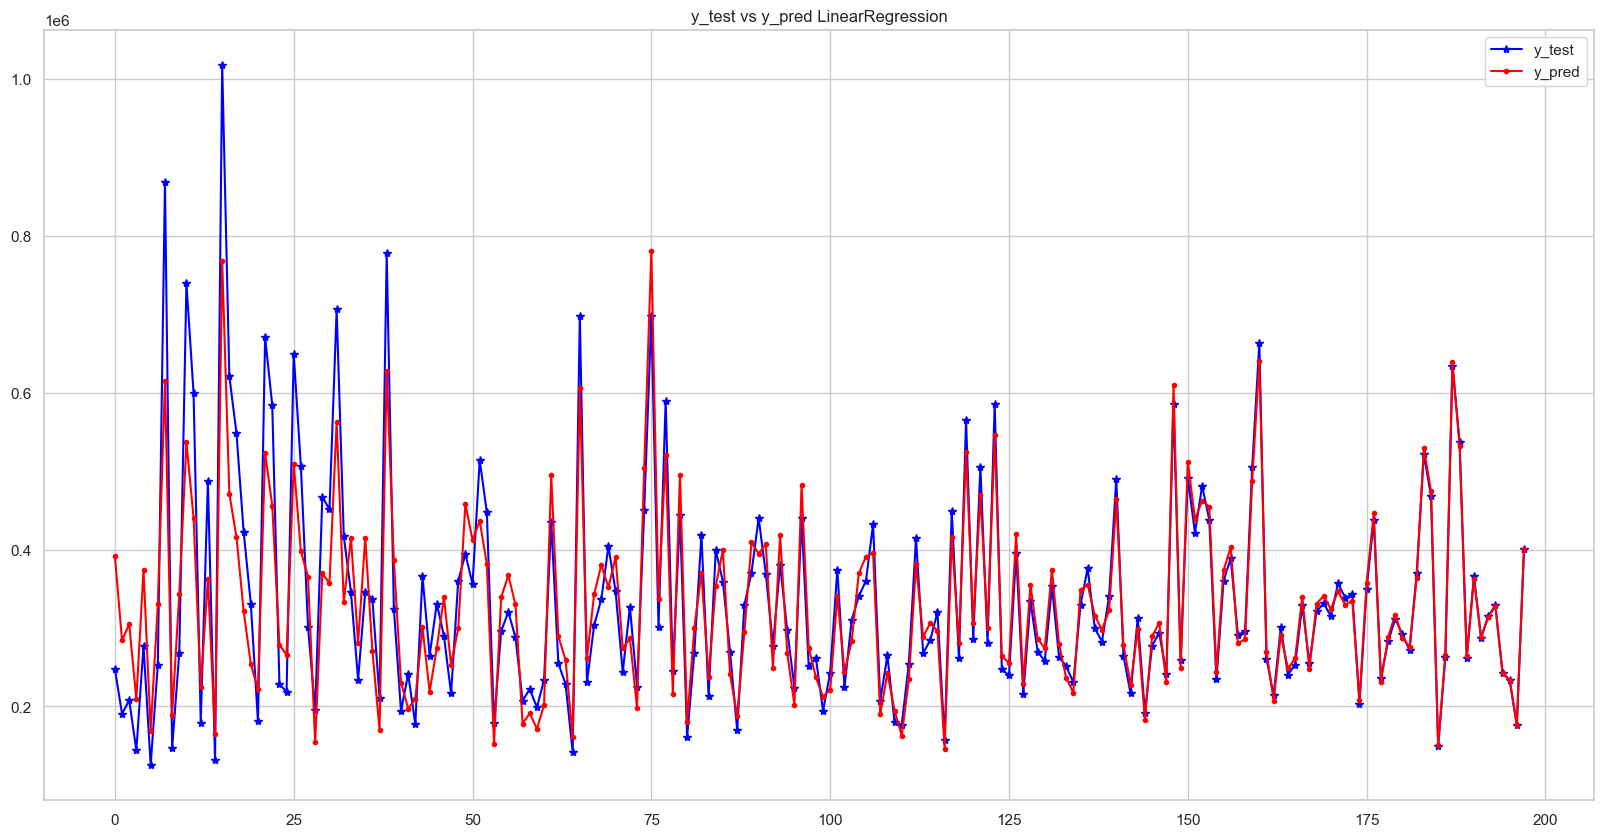

In [21]:
#remove the first two indexes
indexes = indexes[2:]
y_test_2 = y_test.iloc[indexes]
y_pred_2 = y_pred[indexes]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
indexes2 = visualize_test(y_test_2, y_pred_2, ax=axes, model_name='LinearRegression')
#Get the top 10% of those indices
top_10_percent_idx = indexes[:len(indexes) // 10]
# Extract rows from X_test and y_test using these indices
X_test_top_errors = X_test.iloc[top_10_percent_idx]
y_test_top_errors = y_test.iloc[top_10_percent_idx]

#Form a DataFrame
df_top_errors = pd.concat([X_test_top_errors, y_test_top_errors], axis=1)
df_top_errors.head()
df_top_errors.to_csv('top_errors.csv')

## Otros modelos

Una vez hemos establecido un modelo base, podemos pasar a probar otros modelos más complejos. En primer lugar, hacemos una primera ronda de entrenamiento de modelos, en la que probamos varios modelos de regresión con parámetros por defecto. Los modelos que probamos son: RandomForestRegressor, ElasticNet, Lasso, Ridge, DecisionTreeRegressor, KNeighborsRegressor, GradientBoostRegressor, AdaBoostRegressor y CatBoostRegressor. 

Además de estos modelos, hemos probado otros durante el entrenamiento como MLP, SVR, Redes neuronales naive, regresiones polinomiales etc. que no han sido incluidos en el cuaderno dado que sus resultados no han sido tan buenos como los de los modelos incluidos.

Learning rate set to 0.081789
0:	learn: 0.3854393	total: 63ms	remaining: 1m 2s
1:	learn: 0.3630077	total: 68.3ms	remaining: 34.1s
2:	learn: 0.3418851	total: 74.5ms	remaining: 24.8s
3:	learn: 0.3226443	total: 81.3ms	remaining: 20.3s
4:	learn: 0.3053371	total: 88.2ms	remaining: 17.5s
5:	learn: 0.2896939	total: 97.3ms	remaining: 16.1s
6:	learn: 0.2754280	total: 108ms	remaining: 15.3s
7:	learn: 0.2621745	total: 118ms	remaining: 14.6s
8:	learn: 0.2506695	total: 130ms	remaining: 14.3s
9:	learn: 0.2402022	total: 140ms	remaining: 13.9s
10:	learn: 0.2303743	total: 146ms	remaining: 13.1s
11:	learn: 0.2213292	total: 153ms	remaining: 12.6s
12:	learn: 0.2135030	total: 160ms	remaining: 12.1s
13:	learn: 0.2060979	total: 166ms	remaining: 11.7s
14:	learn: 0.1996612	total: 171ms	remaining: 11.2s
15:	learn: 0.1933480	total: 177ms	remaining: 10.9s
16:	learn: 0.1881361	total: 183ms	remaining: 10.6s
17:	learn: 0.1833111	total: 190ms	remaining: 10.4s
18:	learn: 0.1788004	total: 195ms	remaining: 10.1s
19:	lea

KeyboardInterrupt: 

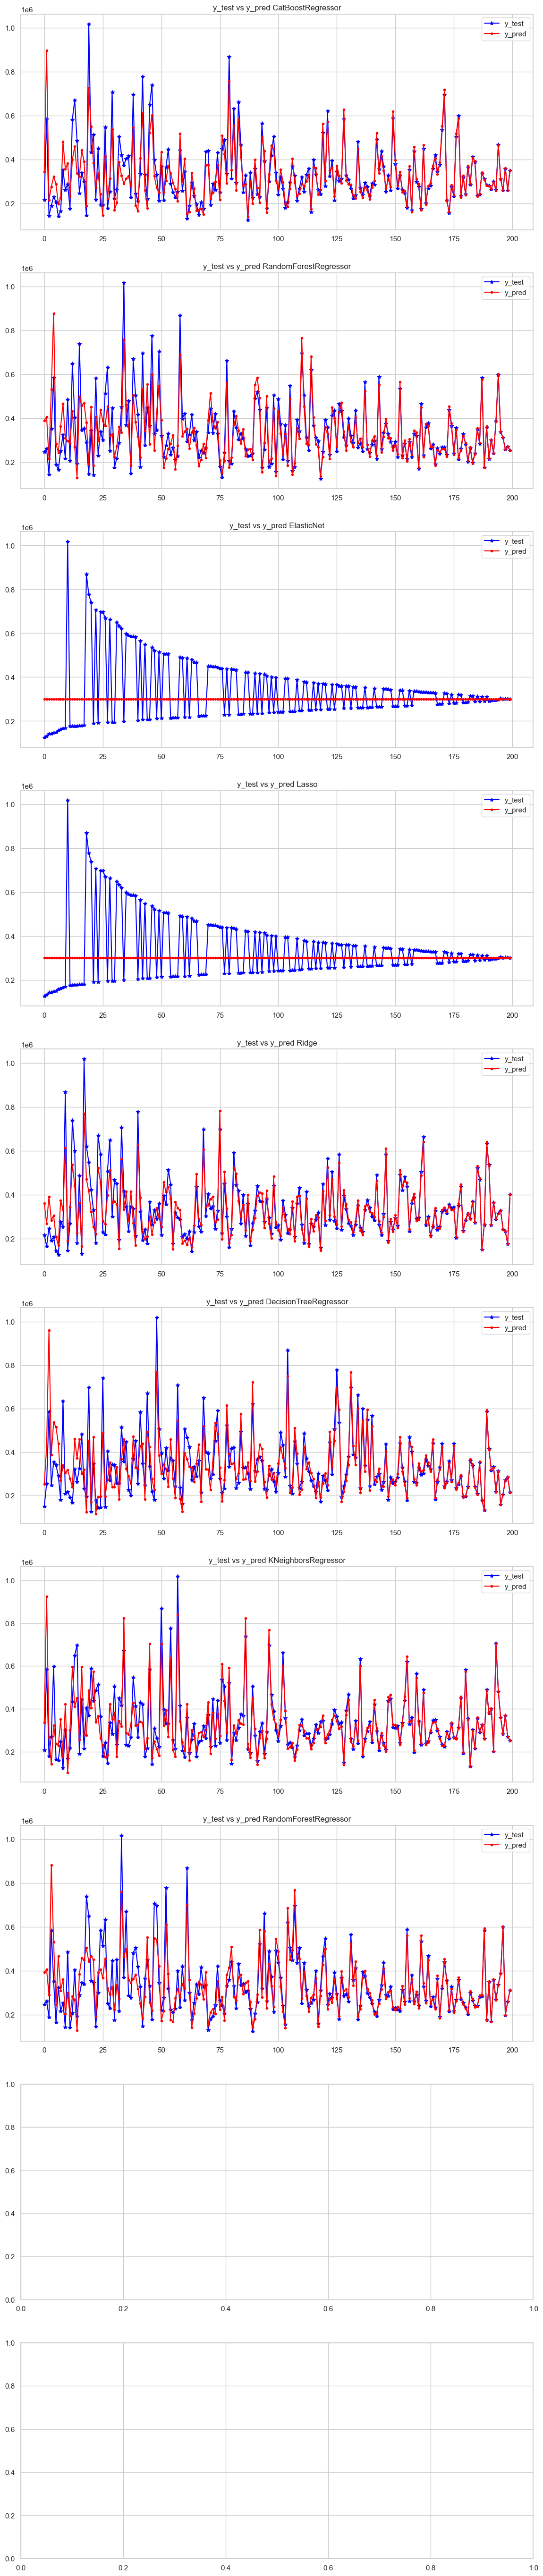

In [22]:
models = [CatBoostRegressor(), RandomForestRegressor(), ElasticNet(), Lasso(), Ridge(), DecisionTreeRegressor(), KNeighborsRegressor(n_neighbors=3, weights='distance'), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    y_pred = np.expm1(y_pred)

    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)
    
plt.show()

### Optimización de hiperparámetros

Entre los modelos que consiguen mejores resultados, decidimos optimizar los hiperparámetros para GradientBoostRegressor y CatBoostRegressor. 

El código muestra cómo usar y mejorar un modelo de predicción con CatBoost. CatBoost es una técnica que se basa en estructuras llamadas "árboles de decisión".

Al comenzar, fijamos una semilla. Esto se hace para que los resultados no cambien cada vez que ejecutemos el código.

Una parte importante del código es la búsqueda de los mejores ajustes para el modelo. Esto se hace con una herramienta llamada GridSearchCV. Esta herramienta prueba diferentes combinaciones y, mediante un proceso llamado "validación cruzada", encuentra la mejor.

Finalmente, con el mejor ajuste encontrado, el modelo hace predicciones sobre datos de prueba. Estas predicciones se comparan con datos reales para ver qué tan bien funciona el modelo.

El código se encuentra comentado ya que el tiempo de ejecución es muy largo, y no es necesario ejecutarlo para obtener los resultados del cuaderno.

In [ ]:
#----------------------------------------
# CatBoostRegressor
#----------------------------------------

# catboost_regressor = CatBoostRegressor(
#     random_seed=0,  # Establece la semilla aleatoria
# )

# # Define tus hiperparámetros específicos de CatBoost
# param_grid = {
#     'depth': [6, 8, 10],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'iterations': [500, 1000, 2000],
#     'l2_leaf_reg': [3, 5, 7],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bylevel': [0.7, 0.8, 0.9],
#     'border_count': [32, 64, 128]
# }

# # Realiza la búsqueda de hiperparámetros
# grid_search = GridSearchCV(catboost_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# # Obtiene el mejor modelo y los mejores hiperparámetros
# best_catboost_regressor = grid_search.best_estimator_
# best_param = grid_search.best_params_

# print(f"Mejores Hiperparámetros: {best_param}")

# y_pred = best_catboost_regressor.predict(X_test, y_test)

# y_pred = np.expm1(y_pred)
# indexes = visualize_test(y_test, y_pred, ax=axes, model_name='CatBoostRegressor')

#----------------------------------------
# GradientBoostingRegressor
#----------------------------------------

# grad_boost = GradientBoostingRegressor()

# distributions = {
#     'learning_rate': uniform(0.01, 0.2),
#     'n_estimators': randint(100, 1000),
#     'max_depth': randint(3, 7),
#     'min_samples_split': uniform(0.01, 0.2),
#     'min_samples_leaf': uniform(0.01, 0.1),
#     'subsample': uniform(0.8, 0.2),
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }

# clf = RandomizedSearchCV(grad_boost, distributions, random_state=0, n_iter=1000, verbose=1, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
# search = clf.fit(X_train, y_train)
# search.best_params_

# Serialización del mejor modelo

Una vez encontrados los mejores hiperparámetros para el modelo, lo serializamos para poder utilizarlo en proyectos futuros. Para ello, utilizamos la librería pickle de Python. De este modo, podemos cargar el modelo en para hacer predicciones en la competición de clase. 

In [ ]:
best_params = {'max_leaves': 8,
          'depth': 3,
          'od_wait': 200,
          'l2_leaf_reg': 3,
          'iterations': 200000,
          'model_size_reg': 0.7,
          'learning_rate': 0.05,
          'random_seed': 42 }

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
final_model = CatBoostRegressor(**best_params)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

y_pred = final_model.predict(X_test)
y_pred = np.expm1(y_pred)

visualize_test(y_test, y_pred, ax=axes, model_name='CatBoostRegressor')

In [ ]:
import pickle

with open("modelo.pickle", "wb") as handler:
    pickle.dump(final_model, handler)

# Conclusiones

A modo de conclusión, los modelos que han conseguido menor error han sido CatBoostRegressor y GradientBoostRegressor, que obtienen MAPE de alrededor de 10-12% en el conjunto de test. Adicionalmente, la regresión lineal obtiene MAPE entre 11-13%, a pesar de ser un modelo más simple. Esto puede deberse a que existen columnas en el dataset que tienen una correlación lineal con el precio, por lo que la regresión lineal es capaz de aprender esta relación. Concretamente, la columna que presenta más este fenómeno es aseos+hab*rating. 

Finalmente, cabe recalcar que el conjunto de datos que estamos utilizando es relativamente pequeño, por lo que los resultados obtenidos pueden ser fácilmente mejorables con un conjunto de datos más grande. Como trabajo futuro, sería interesante emplear métodos más sofisticados de detección de outliers para eliminarlos del conjunto de entrenamiento y mejorar el rendimiento de los modelos, así como técnicas de normalización más avanzadas para normalizar el precio o la obtención de nuevos datos para entrenar los modelos.

# Bibliografía

- [Artículo sobre balanceo de clases en aprendizaje automático](https://proceedings.mlr.press/v74/branco17a/branco17a.pdf)
- [Random Oversampling y Undersampling para clasificación con clases desequilibradas](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)
- [Handling Imbalanced Data by Oversampling with SMOTE and its Variants](https://medium.com/analytics-vidhya/handling-imbalanced-data-by-oversampling-with-smote-and-its-variants-23a4bf188eaf)
- [Notas sobre cómo manejar datos desequilibrados](https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725)
- [Artículos sobre datos desequilibrados](https://medium.com/tag/skewed-data)
- [Libro: "An Introduction to Statistical Learning: with Applications in R" por James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013)](https://www.springer.com/gp/book/9781461471370)

# Integrantes

# Introducción

# Imports

# Funciones

In [ ]:
price_mean = 0
price_std = 0

def visualize_dataframe_distributions(df):
    # Filtrar columnas por tipo de datos
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    n = len(df.columns)  # Numero total de columnas
    side_length = int(np.ceil(np.sqrt(n)))  # Calcula la longitud del lado de la cuadrícula
    
    # 
    fig, axes = plt.subplots(nrows=side_length, ncols=side_length, figsize=(50, 50))
    fig.tight_layout(pad=4.0)
    
    for ax in axes.ravel():
        ax.axis('off')  # Hide all axes initially

    # Plotting numeric columns
    for i, col in enumerate(numeric_cols):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        ax.hist(df[col], bins=30, edgecolor='k')
        ax.set_title(col)
    
    # Plotting categorical columns
    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    
    # Plotting datetime columns
    for i, col in enumerate(datetime_cols, start=len(numeric_cols) + len(categorical_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().sort_index().plot(ax=ax)
        ax.set_title(col)
        
    plt.show()

def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[0:2]
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

def plot_correlation_matrix(df):
    corr = df.corr()
    corr = abs(corr)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred


def visualize_test(y_test, y_pred, ax, model_name):
    perc_diff = abs((y_pred - y_test) / y_test) * 100
    sorted_indexes = np.argsort(perc_diff)[::-1] 
    
    y_test_sorted = y_test.iloc[sorted_indexes]
    y_pred_sorted = y_pred[sorted_indexes]
    
    # paired = sorted(list(zip(y_test, y_pred)))
    # y_test_sorted, y_pred_sorted = zip(*paired)

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)

    print('MAE: {:}'.format(mae/1000))
    print('MAPE: {:.4}'.format(mape*100))

    num_range = np.arange(0, len(y_test))
    ax.plot(num_range, y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(num_range, y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()
    
    return sorted_indexes


def plot_against_precio(df):
    """
    Plot all columns in dataframe df against 'Precio'.
    Assumes that 'Precio' is one of the columns in df.
    """
    # Ensure that Seaborn's aesthetics are being used
    sns.set(style="whitegrid")
    
    # Number of columns to be plotted against 'Precio'
    n = df.shape[1] - 1  # subtract 1 because we won't plot 'Precio' against itself
    
    # Create subplots; You can adjust the size (e.g., figsize) as per your requirements
    fig, axes = plt.subplots(n, 1, figsize=(8, 5*n))
    
    # For every column other than 'Precio', plot it against 'Precio'
    for i, column in enumerate([col for col in df.columns if col != 'Precio']):
        sns.scatterplot(data=df, x='Precio', y=column, ax=axes[i])
        axes[i].set_title(f'{column} vs. Precio')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


def visualize_price_distribution(df, column_name="Precio", title="Price Distribution", color="skyblue", kde=True):
    
    # Check if the column exists in the dataframe
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the dataframe!")
        return
    
    # Set the style for a fancier look
    sns.set(style="whitegrid")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=kde, color=color, bins=30, edgecolor="black", linewidth=0.5)
    
    # Decorate the plot
    plt.title(title, fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y")
    
    # Display the plot
    plt.tight_layout()
    plt.show()



En esta parte del cuaderno definimos la pipeline de procesamiento de datos quehemos encontrado más efectiva para este problema y para el entrenamiento de nuestros modelos. En esta pipeline se definen las transformaciones que se aplicarán a los datos antes de ser utilizados para entrenar los modelos, como normalización, eliminación de columnas poco relevantes para nuestros modelos, creación de nuevas columnas a partir de otras, etc.  
Realmente en este cuaderno se encuentra la solución final que hemos utilizado para entrenar nuestros modelos finales, así como algunas transformaciones que probamos y decidimos no utilizar. Ha sido un proceso iterativo de análisis de los datos y prueba de modelos, en el que hemos ido probando diferentes transformaciones y modelos, y hemos ido descartando los que no nos han dado buenos resultados.

In [ ]:
df = pd.read_csv('train.csv')
df.head()

In [ ]:
columns = df.columns
rows = len(df)
print('Número de filas:', rows)
print('Número de columnas:', len(columns))
print(columns)


In [ ]:
#look for nan value
nans = df.isna().sum()
nans = nans[nans > 0]
print(nans)

In [ ]:
df.set_index('Id', inplace=True)
df.drop(['AguaCorriente', 'GasNatural', 'FosaSeptica', 'Piscina', 'Plan', 'PerimParcela'], axis=1, inplace=True)

**Código Postal**  
El código postal es una variable que puede contener mucha información sobre la propiedad, ya que nos permite identificar la zona en la que se encuentra. Sin embargo, el código postal es una variable categórica, por lo que no podemos utilizarla directamente en un modelo de regresión. Para poder utilizarla, la dividimos en dos columnas: **GrupoPostal** y **RegionPostal**. La primera contiene el primer dígito del código postal, mientras que la segunda contiene los dos primero. De esta forma, podemos utilizar estas columnas como variables categóricas en el modelo y ver si existe correlación entre la zona donde se ubica la propiedad y el precio.

**Variables sintéticas**  
A partir de las columnas existentes, queremos crear columnas nuevas que plasmen información relevante para el análisis e interacciones entre variables de entrada. Durante el desarrollo del proyecto creamos varias columnas que posteriormente no utilizamos dado que o bien introducían ruido o no eran relevantes para nuestros modelos. Estas variables se encuentran comentadas en la parte inferior de la celda. Las columnas que creamos incluyen:   

- **Utilizadas en el modelo final**
    - SinGaraje: realiza la inversa de la columna Garaje, es decir, si la propiedad no tiene garaje, toma el valor 1, y si tiene garaje, toma el valor 0.
    - 3plantas: indica si la casa tiene 3 plantas, ya que se relaciona con un precio más bajo.
    - AgeOfHouse y YearsSinceReform: indican la antigüedad de la casa y el tiempo transcurrido desde la última reforma, respectivamente.   


- **Relaciones entre variables utilizadas en el modelo final**: creamos columnas que representan la interacción entre variables de entrada que tienen una correlación significativa con el precio. 
    - aseos+hab*rating: columna creada a partir de las variables que más correlación tienen con el precio. 
    - synth4-7: variables sintéticas obtenidas de la combinación de las columnas de entrada. Resultan en distribuciones con una alta correlación con el precio, con forma lineal y de "plátano" (curva exponencial)
  
- **No utilizadas en el modelo final**  
    - Reformada: si la vivienda está reformada o no
    - TotalRooms: número total de habitaciones
    - AvgProximity: media entre las variables relacionadas con la distancia a carretera, calle principal y vias de tren. 

Tras hacer análisis de correlación y haber entrenado algunos modelos como regresión lineal (realmente esto es un proceso iterativo en el que íbamos de las celdas posteriores a las anteriores)  decidimos eliminar las columnas que no aportaban información relevante para el análisis (por ejemplo las que en regresión lineal tienen menos importancia), o cuya información ya estaba contenida en alguna de las variables creadas anteriormente (alta correlación con otras variables).

Hacemos one-hot encoding de todas las variables categóricas, e igual que hicimos en el paso anterior, eliminamos aquellas que no son relevantes para nuestros modelos y mantenemos el resto. 

Obtenemos las variables reales y enteras (float e int) y las normalizamos utilizando la normalización Z-Score (centrando y escalando los datos según su media y desviación estándar). No lo hacemos con el precio ya que hay más problemática relacionada con él (outliers, distribución no normal, etc) y la trataremos más adelante. 

En esta celda podemos ver las funciones que hemos utilizado para visualizar distribuciones o relaciones entre variables. Incluyen una función que muestra todas las distribuciones de las variables (visualize_dataframe_distributions), gráficas que muestran relación entre columnas y el precio (plot_against_precio), gráficas que muestran la relación entre columnas dos a dos (sns.pairplot)

En un momento dado, pensamos que era buena idea calcular si alguna de las columnas tenía mucho skew (asimetría) y aplicarle una transformación logarítmica para reducirlo. Sin embargo, tras hacer pruebas con modelos, vimos que no mejoraba el rendimiento, por lo que decidimos no utilizarlo. De todos modos, dejamos el código en la celda siguiente por si en algún momento queremos volver a utilizarlo. Se utiliza una función de scipy.stats para determinar si existe asimetría en la distribución, y para aquellas columnas que tienen asimetría se aplica el logaritmo. Se eliminan valores problemáticos (infinitos) y se normalizan los datos.

Con la siguiente función podemos ver la matriz de correlación de las variables. Esta matriz nos permite ver la relación entre las variables de entrada y el precio, y entre las variables de entrada entre sí. Los valores están en el rango de 0 a 1, ya que vemos la correlación entre variables. Una correlación de 0 indica que no existe relación entre las variables (denotada en azul oscuro), mientras que una correlación de 1 indica que existe una relación lineal perfecta entre las variables (denotada en rojo oscuro).

A continuación, utilizando los valores de la matriz de correlación obtenidos, se han ido realizando pruebas deescartando las variables predictoras que poseían una alta correlación(mayor a un umbral preestablecido de 0.5) y por lo tanto podían dificultar el entrenamiento introduciendo ruido al modelo. 

# Precio: distribución y problemática

In [ ]:
visualize_price_distribution(df, title="Distribución de precios")

In [ ]:
#----------------------------------------
# SMOGN
#----------------------------------------
# from smogn import smoter
# df = smoter(data=df, y='Precio', k = 5, pert = 0.5, samp_method = 'balance')

#----------------------------------------
# Modificación de la distribución de precios
#----------------------------------------

#Calculate the number of bins
# num_bins = 10
# bins = np.linspace(train['Precio'].min(), train['Precio'].max(), num_bins+1)
# mid_points = (bins[:-1] + bins[1:]) / 2

# # Bin the data
# train['binned'] = pd.cut(train['Precio'], bins=bins)
# print(train['binned'].value_counts())
# # Desired normal distribution parameters
# mean = train['Precio'].mean()
# std = train['Precio'].std()

# # Calculate the desired number of samples per bin based on normal distribution
# pdf_values = stats.norm.pdf(mid_points, mean, std)
# desired_samples_per_bin = pdf_values / sum(pdf_values) * len(train)
# print(desired_samples_per_bin)

# # Get unique bin categories
# unique_bins = train['binned'].cat.categories

# # Oversample each bin
# oversampled_dfs = []

# for i, bin_category in enumerate(unique_bins):
#     bin_df = train[train['binned'] == bin_category]
#     num_samples = int(desired_samples_per_bin[i])

#     if not bin_df.empty and num_samples > 0:
#         oversampled_dfs.append(bin_df.sample(num_samples, replace=True))

# if oversampled_dfs:
#     oversampled_train = pd.concat(oversampled_dfs, axis=0).reset_index(drop=True)
#     # Drop the 'binned' column
#     oversampled_train = oversampled_train.drop(columns=['binned'])
# else:
#     print("No bins met the criteria for oversampling.")

Se dividen a continuación los datos del dataset en la muestra de entrenamiento y la de test, con proporciones de 80% y 20%, respectivamente.

Finalmente, en nuestro test de entrenamiento, la combinación de soluciones que hemos aplicado para mejorar la predicción se basa en eliminar colas de la distribución de precios, hacer bootstrap con las muestras de entrenamiento y aplicar una transformación logarítmica para normalizar los datos y cambiar la forma de su distribución ligeramente. 

## Regresión lineal: baseline

**Métricas**:  
Las métricas utilizadas para comprobar el rendimiento de nuestros modelos van a ser dos, MAE y MAPE, ya que permiten comparar el rendimiento de los modelos independientemente de la escala de los datos, además de ser fácilmente interpretables.
- MAE: Mean Absolute Error. Es el error absoluto medio, es decir, la media de la diferencia entre el valor real y el valor predicho.
- MAPE: Mean Absolute Percentage Error. Es el error porcentual absoluto medio, es decir, la media de la diferencia porcentual entre el valor real y el valor predicho.

Es importante analizar en qué muestras se cometen los errores más grandes, ya que esto nos permite saber en qué casos el modelo no funciona bien. Para ello, obtenemos las muestras ordenadas por error absoluto y las guardamos en un dataframe, para su posterior análisis. Este ha sido un paso clave en nuestro proceso de entrenamiento de modelos y análisis de resultados, ya que nos ha permitido identificar los casos en los que los modelos fallan y tomar medidas para solucionarlo.

## Otros modelos

In [ ]:
models = [CatBoostRegressor(), RandomForestRegressor(), ElasticNet(), Lasso(), Ridge(), DecisionTreeRegressor(), KNeighborsRegressor(n_neighbors=3, weights='distance'), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    y_pred = np.expm1(y_pred)

    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)
    
plt.show()

Entre los modelos que consiguen mejores resultados, decidimos optimizar los hiperparámetros para GradientBoostRegressor y CatBoostRegressor. 

El código muestra cómo usar y mejorar un modelo de predicción con CatBoost. CatBoost es una técnica que se basa en estructuras llamadas "árboles de decisión".

Al comenzar, fijamos una semilla. Esto se hace para que los resultados no cambien cada vez que ejecutemos el código.

Una parte importante del código es la búsqueda de los mejores ajustes para el modelo. Esto se hace con una herramienta llamada GridSearchCV. Esta herramienta prueba diferentes combinaciones y, mediante un proceso llamado "validación cruzada", encuentra la mejor.

Finalmente, con el mejor ajuste encontrado, el modelo hace predicciones sobre datos de prueba. Estas predicciones se comparan con datos reales para ver qué tan bien funciona el modelo.

El código se encuentra comentado ya que el tiempo de ejecución es muy largo, y no es necesario ejecutarlo para obtener los resultados del cuaderno.

# Serialización del mejor modelo

In [ ]:
best_params = {'max_leaves': 8,
          'depth': 3,
          'od_wait': 200,
          'l2_leaf_reg': 3,
          'iterations': 200000,
          'model_size_reg': 0.7,
          'learning_rate': 0.05,
          'random_seed': 42 }

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
final_model = CatBoostRegressor(**best_params)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

y_pred = final_model.predict(X_test)
y_pred = np.expm1(y_pred)

visualize_test(y_test, y_pred, ax=axes, model_name='CatBoostRegressor')

# Conclusiones

# Bibliografía

# Integrantes

# Introducción

# Imports

# Funciones

In [ ]:
price_mean = 0
price_std = 0

def visualize_dataframe_distributions(df):
    # Filtrar columnas por tipo de datos
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    n = len(df.columns)  # Numero total de columnas
    side_length = int(np.ceil(np.sqrt(n)))  # Calcula la longitud del lado de la cuadrícula
    
    # 
    fig, axes = plt.subplots(nrows=side_length, ncols=side_length, figsize=(50, 50))
    fig.tight_layout(pad=4.0)
    
    for ax in axes.ravel():
        ax.axis('off')  # Hide all axes initially

    # Plotting numeric columns
    for i, col in enumerate(numeric_cols):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        ax.hist(df[col], bins=30, edgecolor='k')
        ax.set_title(col)
    
    # Plotting categorical columns
    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    
    # Plotting datetime columns
    for i, col in enumerate(datetime_cols, start=len(numeric_cols) + len(categorical_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().sort_index().plot(ax=ax)
        ax.set_title(col)
        
    plt.show()

def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[0:2]
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

def plot_correlation_matrix(df):
    corr = df.corr()
    corr = abs(corr)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred


def visualize_test(y_test, y_pred, ax, model_name):
    perc_diff = abs((y_pred - y_test) / y_test) * 100
    sorted_indexes = np.argsort(perc_diff)[::-1] 
    
    y_test_sorted = y_test.iloc[sorted_indexes]
    y_pred_sorted = y_pred[sorted_indexes]
    
    # paired = sorted(list(zip(y_test, y_pred)))
    # y_test_sorted, y_pred_sorted = zip(*paired)

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)

    print('MAE: {:}'.format(mae/1000))
    print('MAPE: {:.4}'.format(mape*100))

    num_range = np.arange(0, len(y_test))
    ax.plot(num_range, y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(num_range, y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()
    
    return sorted_indexes


def plot_against_precio(df):
    """
    Plot all columns in dataframe df against 'Precio'.
    Assumes that 'Precio' is one of the columns in df.
    """
    # Ensure that Seaborn's aesthetics are being used
    sns.set(style="whitegrid")
    
    # Number of columns to be plotted against 'Precio'
    n = df.shape[1] - 1  # subtract 1 because we won't plot 'Precio' against itself
    
    # Create subplots; You can adjust the size (e.g., figsize) as per your requirements
    fig, axes = plt.subplots(n, 1, figsize=(8, 5*n))
    
    # For every column other than 'Precio', plot it against 'Precio'
    for i, column in enumerate([col for col in df.columns if col != 'Precio']):
        sns.scatterplot(data=df, x='Precio', y=column, ax=axes[i])
        axes[i].set_title(f'{column} vs. Precio')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


def visualize_price_distribution(df, column_name="Precio", title="Price Distribution", color="skyblue", kde=True):
    
    # Check if the column exists in the dataframe
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the dataframe!")
        return
    
    # Set the style for a fancier look
    sns.set(style="whitegrid")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=kde, color=color, bins=30, edgecolor="black", linewidth=0.5)
    
    # Decorate the plot
    plt.title(title, fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y")
    
    # Display the plot
    plt.tight_layout()
    plt.show()



En esta parte del cuaderno definimos la pipeline de procesamiento de datos quehemos encontrado más efectiva para este problema y para el entrenamiento de nuestros modelos. En esta pipeline se definen las transformaciones que se aplicarán a los datos antes de ser utilizados para entrenar los modelos, como normalización, eliminación de columnas poco relevantes para nuestros modelos, creación de nuevas columnas a partir de otras, etc.  
Realmente en este cuaderno se encuentra la solución final que hemos utilizado para entrenar nuestros modelos finales, así como algunas transformaciones que probamos y decidimos no utilizar. Ha sido un proceso iterativo de análisis de los datos y prueba de modelos, en el que hemos ido probando diferentes transformaciones y modelos, y hemos ido descartando los que no nos han dado buenos resultados.

In [ ]:
df = pd.read_csv('train.csv')
df.head()

In [ ]:
columns = df.columns
rows = len(df)
print('Número de filas:', rows)
print('Número de columnas:', len(columns))
print(columns)


In [ ]:
#look for nan value
nans = df.isna().sum()
nans = nans[nans > 0]
print(nans)

In [ ]:
df.set_index('Id', inplace=True)
df.drop(['AguaCorriente', 'GasNatural', 'FosaSeptica', 'Piscina', 'Plan', 'PerimParcela'], axis=1, inplace=True)

**Código Postal**  
El código postal es una variable que puede contener mucha información sobre la propiedad, ya que nos permite identificar la zona en la que se encuentra. Sin embargo, el código postal es una variable categórica, por lo que no podemos utilizarla directamente en un modelo de regresión. Para poder utilizarla, la dividimos en dos columnas: **GrupoPostal** y **RegionPostal**. La primera contiene el primer dígito del código postal, mientras que la segunda contiene los dos primero. De esta forma, podemos utilizar estas columnas como variables categóricas en el modelo y ver si existe correlación entre la zona donde se ubica la propiedad y el precio.

**Variables sintéticas**  
A partir de las columnas existentes, queremos crear columnas nuevas que plasmen información relevante para el análisis e interacciones entre variables de entrada. Durante el desarrollo del proyecto creamos varias columnas que posteriormente no utilizamos dado que o bien introducían ruido o no eran relevantes para nuestros modelos. Estas variables se encuentran comentadas en la parte inferior de la celda. Las columnas que creamos incluyen:   

- **Utilizadas en el modelo final**
    - SinGaraje: realiza la inversa de la columna Garaje, es decir, si la propiedad no tiene garaje, toma el valor 1, y si tiene garaje, toma el valor 0.
    - 3plantas: indica si la casa tiene 3 plantas, ya que se relaciona con un precio más bajo.
    - AgeOfHouse y YearsSinceReform: indican la antigüedad de la casa y el tiempo transcurrido desde la última reforma, respectivamente.   


- **Relaciones entre variables utilizadas en el modelo final**: creamos columnas que representan la interacción entre variables de entrada que tienen una correlación significativa con el precio. 
    - aseos+hab*rating: columna creada a partir de las variables que más correlación tienen con el precio. 
    - synth4-7: variables sintéticas obtenidas de la combinación de las columnas de entrada. Resultan en distribuciones con una alta correlación con el precio, con forma lineal y de "plátano" (curva exponencial)
  
- **No utilizadas en el modelo final**  
    - Reformada: si la vivienda está reformada o no
    - TotalRooms: número total de habitaciones
    - AvgProximity: media entre las variables relacionadas con la distancia a carretera, calle principal y vias de tren. 

Tras hacer análisis de correlación y haber entrenado algunos modelos como regresión lineal (realmente esto es un proceso iterativo en el que íbamos de las celdas posteriores a las anteriores)  decidimos eliminar las columnas que no aportaban información relevante para el análisis (por ejemplo las que en regresión lineal tienen menos importancia), o cuya información ya estaba contenida en alguna de las variables creadas anteriormente (alta correlación con otras variables).

Hacemos one-hot encoding de todas las variables categóricas, e igual que hicimos en el paso anterior, eliminamos aquellas que no son relevantes para nuestros modelos y mantenemos el resto. 

Obtenemos las variables reales y enteras (float e int) y las normalizamos utilizando la normalización Z-Score (centrando y escalando los datos según su media y desviación estándar). No lo hacemos con el precio ya que hay más problemática relacionada con él (outliers, distribución no normal, etc) y la trataremos más adelante. 

En esta celda podemos ver las funciones que hemos utilizado para visualizar distribuciones o relaciones entre variables. Incluyen una función que muestra todas las distribuciones de las variables (visualize_dataframe_distributions), gráficas que muestran relación entre columnas y el precio (plot_against_precio), gráficas que muestran la relación entre columnas dos a dos (sns.pairplot)

En un momento dado, pensamos que era buena idea calcular si alguna de las columnas tenía mucho skew (asimetría) y aplicarle una transformación logarítmica para reducirlo. Sin embargo, tras hacer pruebas con modelos, vimos que no mejoraba el rendimiento, por lo que decidimos no utilizarlo. De todos modos, dejamos el código en la celda siguiente por si en algún momento queremos volver a utilizarlo. Se utiliza una función de scipy.stats para determinar si existe asimetría en la distribución, y para aquellas columnas que tienen asimetría se aplica el logaritmo. Se eliminan valores problemáticos (infinitos) y se normalizan los datos.

Con la siguiente función podemos ver la matriz de correlación de las variables. Esta matriz nos permite ver la relación entre las variables de entrada y el precio, y entre las variables de entrada entre sí. Los valores están en el rango de 0 a 1, ya que vemos la correlación entre variables. Una correlación de 0 indica que no existe relación entre las variables (denotada en azul oscuro), mientras que una correlación de 1 indica que existe una relación lineal perfecta entre las variables (denotada en rojo oscuro).

A continuación, utilizando los valores de la matriz de correlación obtenidos, se han ido realizando pruebas deescartando las variables predictoras que poseían una alta correlación(mayor a un umbral preestablecido de 0.5) y por lo tanto podían dificultar el entrenamiento introduciendo ruido al modelo. 

# Precio: distribución y problemática

In [ ]:
visualize_price_distribution(df, title="Distribución de precios")

In [ ]:
#----------------------------------------
# SMOGN
#----------------------------------------
# from smogn import smoter
# df = smoter(data=df, y='Precio', k = 5, pert = 0.5, samp_method = 'balance')

#----------------------------------------
# Modificación de la distribución de precios
#----------------------------------------

#Calculate the number of bins
# num_bins = 10
# bins = np.linspace(train['Precio'].min(), train['Precio'].max(), num_bins+1)
# mid_points = (bins[:-1] + bins[1:]) / 2

# # Bin the data
# train['binned'] = pd.cut(train['Precio'], bins=bins)
# print(train['binned'].value_counts())
# # Desired normal distribution parameters
# mean = train['Precio'].mean()
# std = train['Precio'].std()

# # Calculate the desired number of samples per bin based on normal distribution
# pdf_values = stats.norm.pdf(mid_points, mean, std)
# desired_samples_per_bin = pdf_values / sum(pdf_values) * len(train)
# print(desired_samples_per_bin)

# # Get unique bin categories
# unique_bins = train['binned'].cat.categories

# # Oversample each bin
# oversampled_dfs = []

# for i, bin_category in enumerate(unique_bins):
#     bin_df = train[train['binned'] == bin_category]
#     num_samples = int(desired_samples_per_bin[i])

#     if not bin_df.empty and num_samples > 0:
#         oversampled_dfs.append(bin_df.sample(num_samples, replace=True))

# if oversampled_dfs:
#     oversampled_train = pd.concat(oversampled_dfs, axis=0).reset_index(drop=True)
#     # Drop the 'binned' column
#     oversampled_train = oversampled_train.drop(columns=['binned'])
# else:
#     print("No bins met the criteria for oversampling.")

Se dividen a continuación los datos del dataset en la muestra de entrenamiento y la de test, con proporciones de 80% y 20%, respectivamente.

Finalmente, en nuestro test de entrenamiento, la combinación de soluciones que hemos aplicado para mejorar la predicción se basa en eliminar colas de la distribución de precios, hacer bootstrap con las muestras de entrenamiento y aplicar una transformación logarítmica para normalizar los datos y cambiar la forma de su distribución ligeramente. 

## Regresión lineal: baseline

**Métricas**:  
Las métricas utilizadas para comprobar el rendimiento de nuestros modelos van a ser dos, MAE y MAPE, ya que permiten comparar el rendimiento de los modelos independientemente de la escala de los datos, además de ser fácilmente interpretables.
- MAE: Mean Absolute Error. Es el error absoluto medio, es decir, la media de la diferencia entre el valor real y el valor predicho.
- MAPE: Mean Absolute Percentage Error. Es el error porcentual absoluto medio, es decir, la media de la diferencia porcentual entre el valor real y el valor predicho.

Es importante analizar en qué muestras se cometen los errores más grandes, ya que esto nos permite saber en qué casos el modelo no funciona bien. Para ello, obtenemos las muestras ordenadas por error absoluto y las guardamos en un dataframe, para su posterior análisis. Este ha sido un paso clave en nuestro proceso de entrenamiento de modelos y análisis de resultados, ya que nos ha permitido identificar los casos en los que los modelos fallan y tomar medidas para solucionarlo.

## Otros modelos

In [ ]:
models = [CatBoostRegressor(), RandomForestRegressor(), ElasticNet(), Lasso(), Ridge(), DecisionTreeRegressor(), KNeighborsRegressor(n_neighbors=3, weights='distance'), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    y_pred = np.expm1(y_pred)

    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)
    
plt.show()

Entre los modelos que consiguen mejores resultados, decidimos optimizar los hiperparámetros para GradientBoostRegressor y CatBoostRegressor. 

El código muestra cómo usar y mejorar un modelo de predicción con CatBoost. CatBoost es una técnica que se basa en estructuras llamadas "árboles de decisión".

Al comenzar, fijamos una semilla. Esto se hace para que los resultados no cambien cada vez que ejecutemos el código.

Una parte importante del código es la búsqueda de los mejores ajustes para el modelo. Esto se hace con una herramienta llamada GridSearchCV. Esta herramienta prueba diferentes combinaciones y, mediante un proceso llamado "validación cruzada", encuentra la mejor.

Finalmente, con el mejor ajuste encontrado, el modelo hace predicciones sobre datos de prueba. Estas predicciones se comparan con datos reales para ver qué tan bien funciona el modelo.

El código se encuentra comentado ya que el tiempo de ejecución es muy largo, y no es necesario ejecutarlo para obtener los resultados del cuaderno.

# Serialización del mejor modelo

In [ ]:
best_params = {'max_leaves': 8,
          'depth': 3,
          'od_wait': 200,
          'l2_leaf_reg': 3,
          'iterations': 200000,
          'model_size_reg': 0.7,
          'learning_rate': 0.05,
          'random_seed': 42 }

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
final_model = CatBoostRegressor(**best_params)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

y_pred = final_model.predict(X_test)
y_pred = np.expm1(y_pred)

visualize_test(y_test, y_pred, ax=axes, model_name='CatBoostRegressor')

# Conclusiones

# Bibliografía

# Integrantes

# Imports

In [ ]:
price_mean = 0
price_std = 0

def visualize_dataframe_distributions(df):
    # Filtrar columnas por tipo de datos
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    n = len(df.columns)  # Numero total de columnas
    side_length = int(np.ceil(np.sqrt(n)))  # Calcula la longitud del lado de la cuadrícula
    
    # 
    fig, axes = plt.subplots(nrows=side_length, ncols=side_length, figsize=(50, 50))
    fig.tight_layout(pad=4.0)
    
    for ax in axes.ravel():
        ax.axis('off')  # Hide all axes initially

    # Plotting numeric columns
    for i, col in enumerate(numeric_cols):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        ax.hist(df[col], bins=30, edgecolor='k')
        ax.set_title(col)
    
    # Plotting categorical columns
    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    
    # Plotting datetime columns
    for i, col in enumerate(datetime_cols, start=len(numeric_cols) + len(categorical_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().sort_index().plot(ax=ax)
        ax.set_title(col)
        
    plt.show()

def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[0:2]
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

def plot_correlation_matrix(df):
    corr = df.corr()
    corr = abs(corr)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred


def visualize_test(y_test, y_pred, ax, model_name):
    perc_diff = abs((y_pred - y_test) / y_test) * 100
    sorted_indexes = np.argsort(perc_diff)[::-1] 
    
    y_test_sorted = y_test.iloc[sorted_indexes]
    y_pred_sorted = y_pred[sorted_indexes]
    
    # paired = sorted(list(zip(y_test, y_pred)))
    # y_test_sorted, y_pred_sorted = zip(*paired)

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)

    print('MAE: {:}'.format(mae/1000))
    print('MAPE: {:.4}'.format(mape*100))

    num_range = np.arange(0, len(y_test))
    ax.plot(num_range, y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(num_range, y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()
    
    return sorted_indexes


def plot_against_precio(df):
    """
    Plot all columns in dataframe df against 'Precio'.
    Assumes that 'Precio' is one of the columns in df.
    """
    # Ensure that Seaborn's aesthetics are being used
    sns.set(style="whitegrid")
    
    # Number of columns to be plotted against 'Precio'
    n = df.shape[1] - 1  # subtract 1 because we won't plot 'Precio' against itself
    
    # Create subplots; You can adjust the size (e.g., figsize) as per your requirements
    fig, axes = plt.subplots(n, 1, figsize=(8, 5*n))
    
    # For every column other than 'Precio', plot it against 'Precio'
    for i, column in enumerate([col for col in df.columns if col != 'Precio']):
        sns.scatterplot(data=df, x='Precio', y=column, ax=axes[i])
        axes[i].set_title(f'{column} vs. Precio')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


def visualize_price_distribution(df, column_name="Precio", title="Price Distribution", color="skyblue", kde=True):
    
    # Check if the column exists in the dataframe
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the dataframe!")
        return
    
    # Set the style for a fancier look
    sns.set(style="whitegrid")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=kde, color=color, bins=30, edgecolor="black", linewidth=0.5)
    
    # Decorate the plot
    plt.title(title, fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y")
    
    # Display the plot
    plt.tight_layout()
    plt.show()



In [ ]:
df = pd.read_csv('train.csv')
df.head()

Id               Tipo  FechaConstruccion  FechaReforma  Plantas     Plan   
0   1  Chalet individual               2003          2003        2  Antiguo  \
1   2  Chalet individual               1976          1976        1  Antiguo   
2   3  Chalet individual               2001          2002        2  Antiguo   
3   4  Chalet individual               1915          1970        2    Nuevo   
4   5  Chalet individual               2000          2000        2  Antiguo   

   PAU               CatParcela  PerimParcela  Superficie  ...  AguaCorriente   
0    0  Residencial unifamiliar         79.25      785.03  ...              1  \
1    0  Residencial unifamiliar         97.54      891.87  ...              1   
2    0  Residencial unifamiliar         82.91     1045.16  ...              1   
3    0  Residencial unifamiliar         73.15      887.22  ...              1   
4    0  Residencial unifamiliar        102.41     1324.80  ...              1   

   FosaSeptica        Situacion     CP  ProxCarretera  ProxCallePrincipal   
0            0         Interior  60061              0                   0  \
1            0  Frontal 2 lados  50018              0                   1   
2            0         Interior  60061              0                   0   
3            0          Esquina  62451              0                   0   
4            0  Frontal 2 lados  60706              0                   0   

   ProxViasTren Estado RatingEstrellas  Precio  
0             0      5             3.5  375497  
1             0      8             3.0  339946  
2             0      5             3.5  402511  
3             0      5             3.5  272706  
4             0      5             4.0  450236  

[5 rows x 31 columns]

In [ ]:
#look for nan value
nans = df.isna().sum()
nans = nans[nans > 0]
print(nans)

Plan            233
PerimParcela    173
dtype: int64


**Código Postal**  
El código postal es una variable que puede contener mucha información sobre la propiedad, ya que nos permite identificar la zona en la que se encuentra. Sin embargo, el código postal es una variable categórica, por lo que no podemos utilizarla directamente en un modelo de regresión. Para poder utilizarla, la dividimos en dos columnas: **GrupoPostal** y **RegionPostal**. La primera contiene el primer dígito del código postal, mientras que la segunda contiene los dos primero. De esta forma, podemos utilizar estas columnas como variables categóricas en el modelo y ver si existe correlación entre la zona donde se ubica la propiedad y el precio.

Tras hacer análisis de correlación y haber entrenado algunos modelos como regresión lineal (realmente esto es un proceso iterativo en el que íbamos de las celdas posteriores a las anteriores)  decidimos eliminar las columnas que no aportaban información relevante para el análisis (por ejemplo las que en regresión lineal tienen menos importancia), o cuya información ya estaba contenida en alguna de las variables creadas anteriormente (alta correlación con otras variables).

Obtenemos las variables reales y enteras (float e int) y las normalizamos utilizando la normalización Z-Score (centrando y escalando los datos según su media y desviación estándar). No lo hacemos con el precio ya que hay más problemática relacionada con él (outliers, distribución no normal, etc) y la trataremos más adelante. 

En un momento dado, pensamos que era buena idea calcular si alguna de las columnas tenía mucho skew (asimetría) y aplicarle una transformación logarítmica para reducirlo. Sin embargo, tras hacer pruebas con modelos, vimos que no mejoraba el rendimiento, por lo que decidimos no utilizarlo. De todos modos, dejamos el código en la celda siguiente por si en algún momento queremos volver a utilizarlo. Se utiliza una función de scipy.stats para determinar si existe asimetría en la distribución, y para aquellas columnas que tienen asimetría se aplica el logaritmo. Se eliminan valores problemáticos (infinitos) y se normalizan los datos.

A continuación, utilizando los valores de la matriz de correlación obtenidos, se han ido realizando pruebas deescartando las variables predictoras que poseían una alta correlación(mayor a un umbral preestablecido de 0.5) y por lo tanto podían dificultar el entrenamiento introduciendo ruido al modelo. 

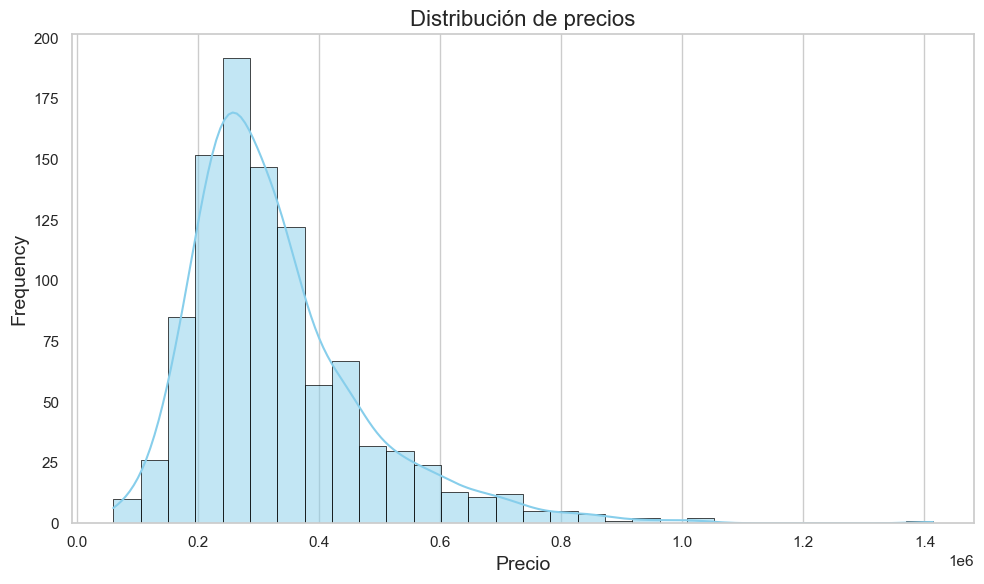

In [ ]:
visualize_price_distribution(df, title="Distribución de precios")

Se dividen a continuación los datos del dataset en la muestra de entrenamiento y la de test, con proporciones de 80% y 20%, respectivamente.

## Regresión lineal: baseline

Es importante analizar en qué muestras se cometen los errores más grandes, ya que esto nos permite saber en qué casos el modelo no funciona bien. Para ello, obtenemos las muestras ordenadas por error absoluto y las guardamos en un dataframe, para su posterior análisis. Este ha sido un paso clave en nuestro proceso de entrenamiento de modelos y análisis de resultados, ya que nos ha permitido identificar los casos en los que los modelos fallan y tomar medidas para solucionarlo.

Learning rate set to 0.081789
0:	learn: 0.3852654	total: 5.56ms	remaining: 5.56s
1:	learn: 0.3623120	total: 9.61ms	remaining: 4.8s
2:	learn: 0.3416234	total: 13.2ms	remaining: 4.38s
3:	learn: 0.3226186	total: 17.2ms	remaining: 4.29s
4:	learn: 0.3053701	total: 21ms	remaining: 4.18s
5:	learn: 0.2899013	total: 25ms	remaining: 4.15s
6:	learn: 0.2755969	total: 29.1ms	remaining: 4.13s
7:	learn: 0.2623794	total: 33ms	remaining: 4.1s
8:	learn: 0.2506375	total: 36.8ms	remaining: 4.05s
9:	learn: 0.2400493	total: 40.7ms	remaining: 4.03s
10:	learn: 0.2300409	total: 44.3ms	remaining: 3.99s
11:	learn: 0.2208683	total: 48.2ms	remaining: 3.97s
12:	learn: 0.2131627	total: 52.2ms	remaining: 3.96s
13:	learn: 0.2056761	total: 55.8ms	remaining: 3.93s
14:	learn: 0.1992678	total: 59.7ms	remaining: 3.92s
15:	learn: 0.1932311	total: 63.5ms	remaining: 3.91s
16:	learn: 0.1875192	total: 67.4ms	remaining: 3.9s
17:	learn: 0.1825500	total: 71.3ms	remaining: 3.89s
18:	learn: 0.1780976	total: 75.2ms	remaining: 3.88s
1

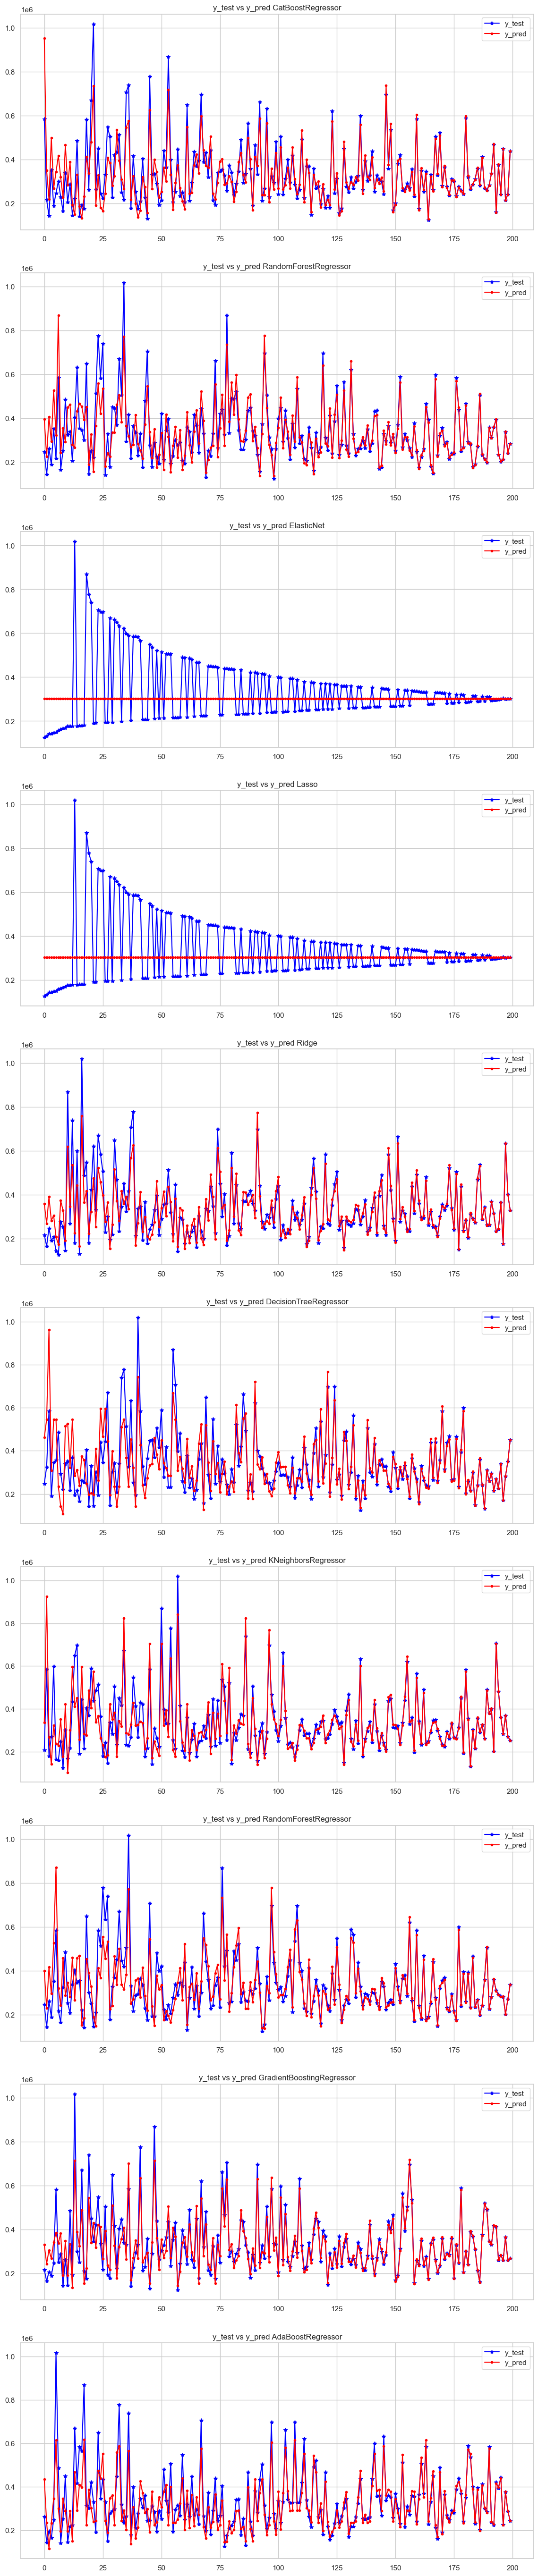

In [ ]:
models = [CatBoostRegressor(), RandomForestRegressor(), ElasticNet(), Lasso(), Ridge(), DecisionTreeRegressor(), KNeighborsRegressor(n_neighbors=3, weights='distance'), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    y_pred = np.expm1(y_pred)

    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)
    
plt.show()

# Serialización del mejor modelo

# Conclusiones